# Introduction

This notebook will contain an analysis of two distinct datasets, each corresponding to a different dataset type: experimental and simulated. Both datasets apply to a comparable building, highlighting the alignment between experimental and simulated scenarios. Experimental and simulation data were based on a small commercial building located in Iowa. These data covered different seasons, namely summer, winter and transitional periods, to allow a comprehensive assessment of the building's behavior under different conditions.

Dataset contains following data:

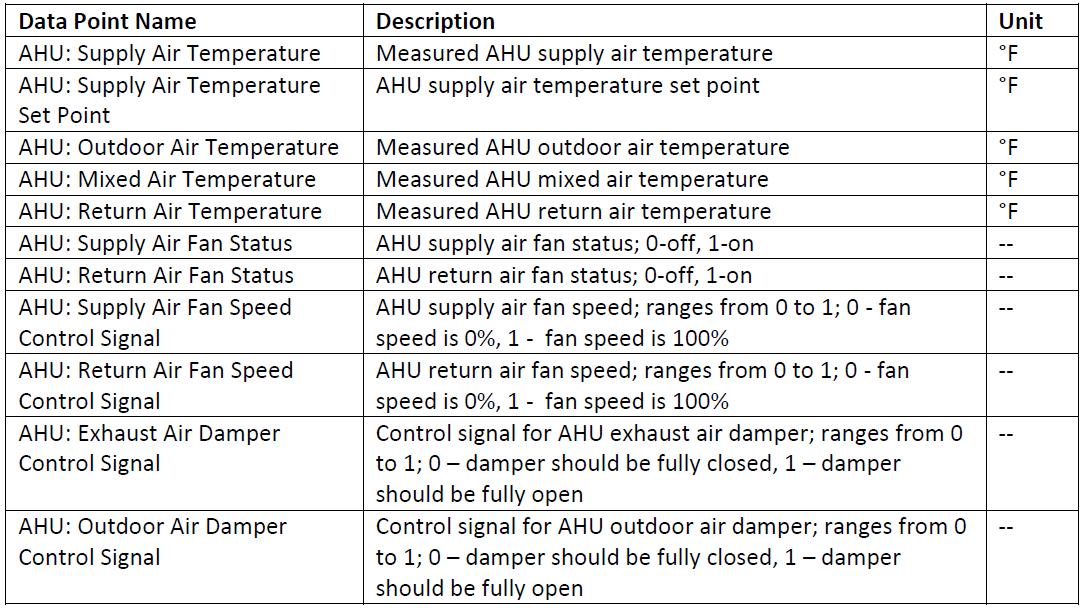
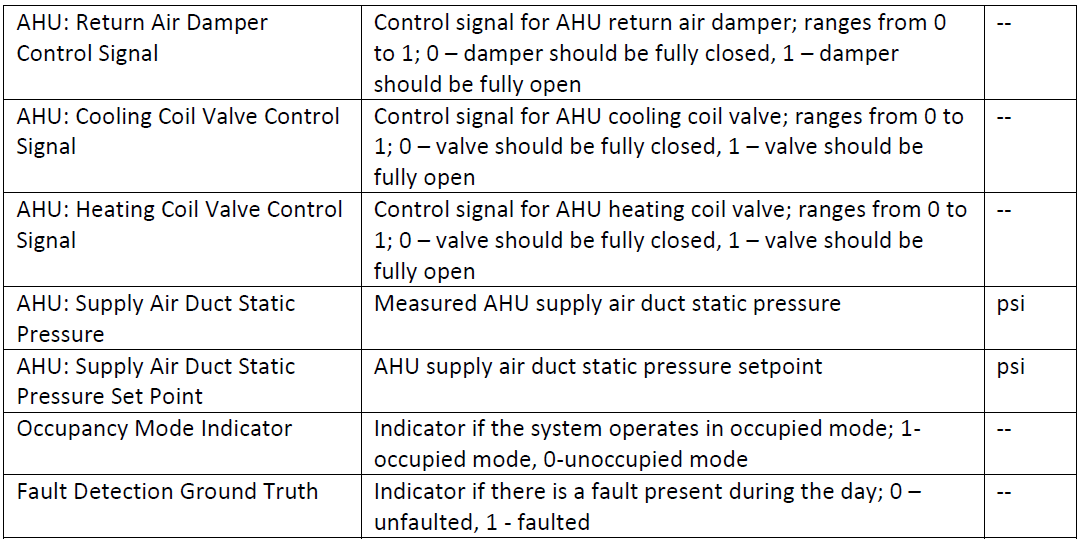

In the actual building, faults were manualy introduced into the control system for a duration of one day, as outlined in the table provided below:

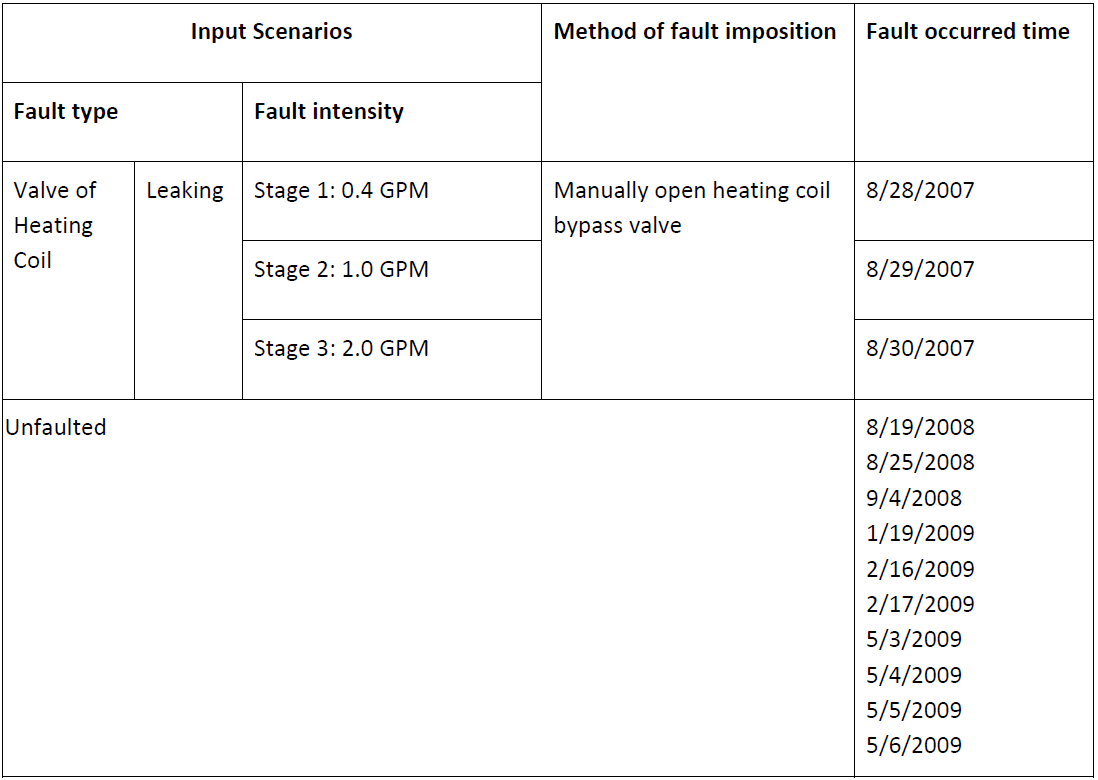

Similarly, within the simulation context, faults were manually introduced into the system for a single day, mirroring the approach delineated in the following table:

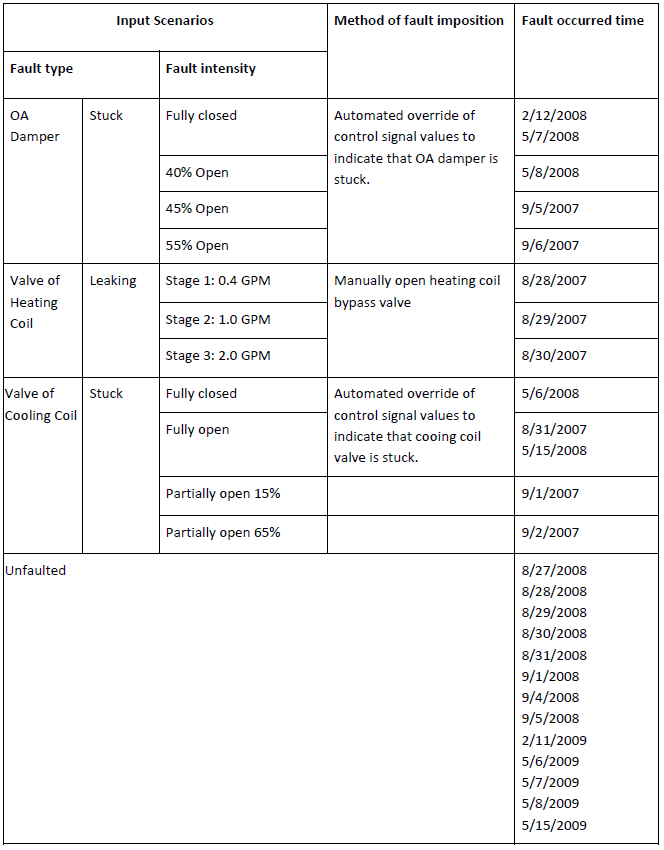

It's evident that the simulated dataset have a broader spectrum of fault types. Interestingly, there exists an overlap between faults featured in both the experimental and simulated datasets. This overlap provides a unique opportunity to put together models developed using distinct tools and check whether a model trained with simulated data can effectively generalize to real building data. This comparison promises valuable insights into the models' adaptability and performance across different scenarios.

# Import of the relevant libraries and notebook preparation

In [55]:
import sys
import os

In [56]:
src_path = os.path.join(os.getcwd(), "..", "src")
sys.path.append(src_path)

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from helper_functions import convert_date, train_evaluate_classification_models, train_evaluate_regression_models
import copy

In [58]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [59]:
# preparing list of classifiacation algorithms for comparison and to choose the best one
classifiers = [['KNeighborsClassifier', KNeighborsClassifier()],
              ['MLPClassifier',MLPClassifier()],
              ['AdaBoostClassifier',AdaBoostClassifier()],
              ['GradientBoostingClassifier',GradientBoostingClassifier()],
              ['CatBoostClassifier', CatBoostClassifier()],
              ['XGBClassifier', XGBClassifier()],
              ['BaggingClassifier', BaggingClassifier()],
              ['RandomForestClassifier', RandomForestClassifier()],
              ['DecisionTreeClassifier', DecisionTreeClassifier()],
              ['LogisticRegression', LogisticRegression()]]

In [60]:
warnings.filterwarnings("ignore")

In [61]:
csv_file_path_1 = os.path.join("..", "data", "MZVAV-2-1.csv")
csv_file_path_2 = os.path.join("..", "data", "MZVAV-2-2.csv")

In [62]:
raw_data_exp = pd.read_csv(csv_file_path_1)

In [63]:
raw_data_sim = pd.read_csv(csv_file_path_2)

# Experimental dataset

## Data exploration and feature engineering

In [64]:
raw_data_exp.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
12399,2/17/2009 14:39,64.84,65,30.47,55.61,70.18,1,1,0.72,0.57,1.00,0.47,0.47,0.00,0.84,1.4,1.41,1,0
17939,5/6/2009 10:59,54.39,55,70.05,69.30,73.02,1,1,0.73,0.58,0.47,1.00,1.00,0.31,0.00,1.4,1.39,1,0
4815,8/19/2008 8:15,55.90,55,77.14,73.76,74.60,1,1,0.61,0.49,0.40,0.40,0.40,0.27,0.00,1.4,1.36,1,0
21244,5/31/2009 18:04,58.92,55,79.83,74.18,71.34,1,1,0.91,0.73,0.40,0.40,0.40,1.00,0.00,1.4,1.52,0,0
12305,2/17/2009 13:05,65.59,65,30.70,55.83,70.18,1,1,0.72,0.57,1.00,0.47,0.47,0.00,0.84,1.4,1.41,1,0


In [65]:
raw_data_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 19 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Datetime                                        21600 non-null  object 
 1   AHU: Supply Air Temperature                     21600 non-null  float64
 2   AHU: Supply Air Temperature Set Point           21600 non-null  int64  
 3   AHU: Outdoor Air Temperature                    21600 non-null  float64
 4   AHU: Mixed Air Temperature                      21600 non-null  float64
 5   AHU: Return Air Temperature                     21600 non-null  float64
 6   AHU: Supply Air Fan Status                      21600 non-null  int64  
 7   AHU: Return Air Fan Status                      21600 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal        21600 non-null  float64
 9   AHU: Return Air Fan Speed Control Signa

The dataset is devoid of any null values and object-type columns, rendering data cleaning unnecessary in these aspects. The sole exception pertains to the "Datetime" column, which will undergo a transformation into the DateTime data format.

In [66]:
# Changing data type of the Datetime column
raw_data_exp['Datetime'] = pd.to_datetime(raw_data_exp['Datetime'])

In [67]:
# Preparing datasets for Boxplot visualisation
temp_col = [col for col in raw_data_exp.columns if "Temp" in col]
control_col = [col for col in raw_data_exp.columns if "Control" in col]
pressure_col = [col for col in raw_data_exp.columns if "Pressure" in col]
temp_data = raw_data_exp[temp_col].melt(var_name='Temperature column', value_name='Temperature in Fahrenheit')
control_data = raw_data_exp[control_col].melt(var_name='Control value column', value_name='0-1')
pressure_data = raw_data_exp[pressure_col].melt(var_name='Pressure column', value_name='Pressure in Psi')

[Text(0, 0, 'AHU: Supply Air Temperature'),
 Text(1, 0, 'AHU: Supply Air Temperature Set Point'),
 Text(2, 0, 'AHU: Outdoor Air Temperature'),
 Text(3, 0, 'AHU: Mixed Air Temperature'),
 Text(4, 0, 'AHU: Return Air Temperature')]

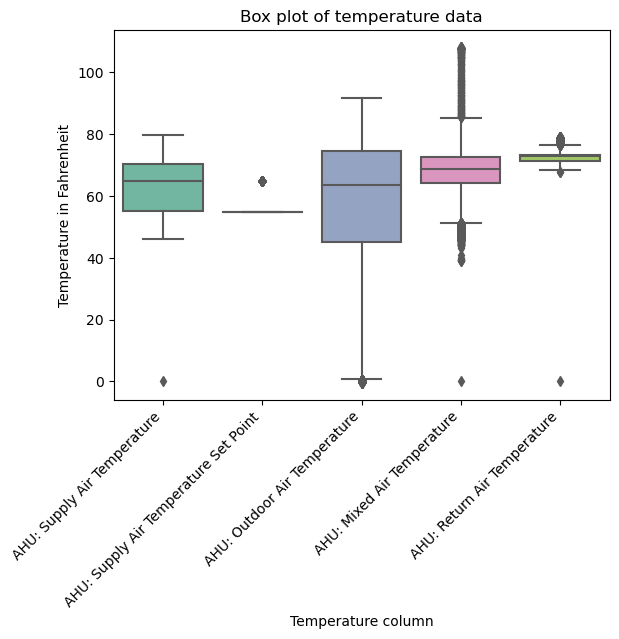

In [68]:
ax = sns.boxplot(x='Temperature column', y='Temperature in Fahrenheit', data=temp_data, palette="Set2")
plt.title("Box plot of temperature data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Fan Speed Control Signal'),
 Text(1, 0, 'AHU: Return Air Fan Speed Control Signal'),
 Text(2, 0, 'AHU: Exhaust Air Damper Control Signal  '),
 Text(3, 0, 'AHU: Outdoor Air Damper Control Signal  '),
 Text(4, 0, 'AHU: Return Air Damper Control Signal'),
 Text(5, 0, 'AHU: Cooling Coil Valve Control Signal'),
 Text(6, 0, 'AHU: Heating Coil Valve Control Signal')]

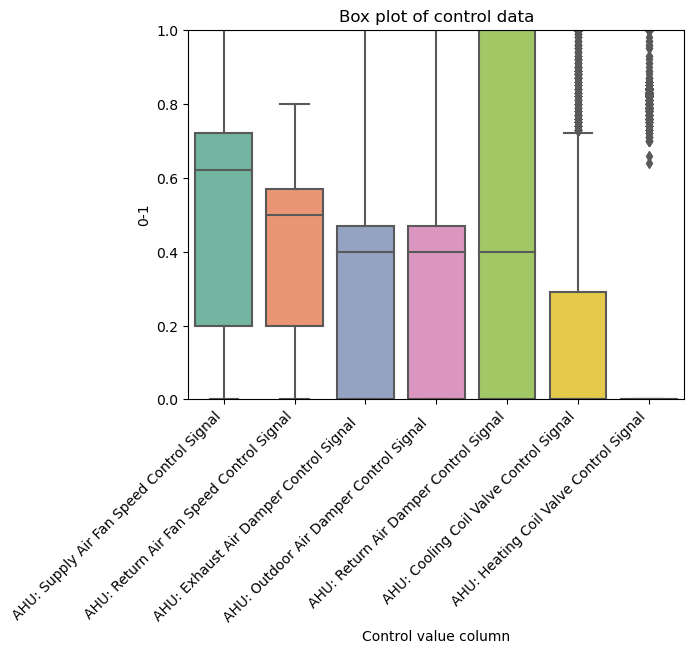

In [69]:
ax = sns.boxplot(x='Control value column', y='0-1', data=control_data, palette="Set2")
plt.title("Box plot of control data")
plt.ylim(0,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Duct Static Pressure Set Point'),
 Text(1, 0, 'AHU: Supply Air Duct Static Pressure ')]

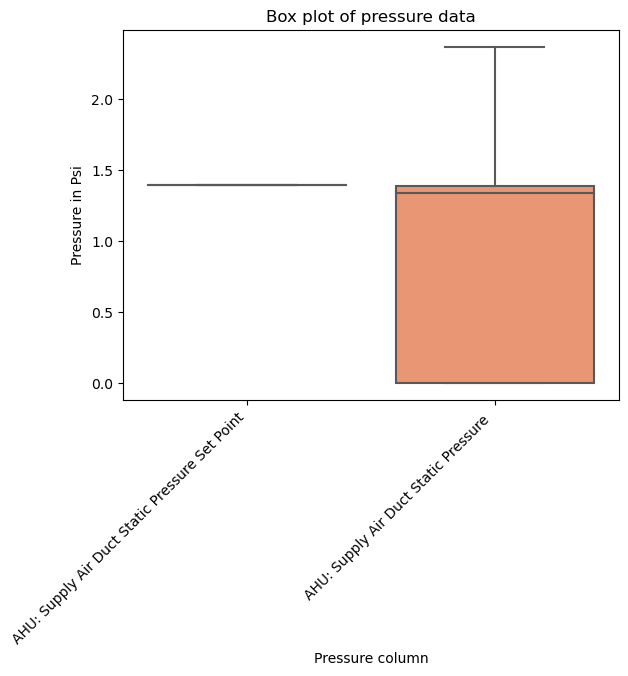

In [70]:
ax = sns.boxplot(x='Pressure column', y='Pressure in Psi', data=pressure_data, palette="Set2")
plt.title("Box plot of pressure data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [71]:
raw_data_exp.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
count,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,2.160000e+04,21600.000000,21600.000000,21600.000000
mean,62.996525,57.000463,58.220122,67.488618,72.611413,0.534722,0.533611,0.474657,0.398145,0.341757,0.331989,0.443025,0.168748,0.083330,1.400000e+00,0.738494,0.500000,0.133333
std,7.372700,4.000440,21.458405,7.875141,1.679548,0.498804,0.498881,0.261236,0.189342,0.372642,0.368341,0.400821,0.252140,0.249985,5.278122e-13,0.695622,0.500012,0.339943
min,0.000000,55.000000,-0.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000e+00,0.000000,0.000000,0.000000
25%,55.150000,55.000000,44.980000,64.100000,71.340000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000e+00,0.000000,0.000000,0.000000
50%,64.840000,55.000000,63.640000,68.660000,72.810000,1.000000,1.000000,0.620000,0.500000,0.400000,0.400000,0.400000,0.000000,0.000000,1.400000e+00,1.340000,0.500000,0.000000
75%,70.430000,55.000000,74.550000,72.590000,73.440000,1.000000,1.000000,0.720000,0.570000,0.470000,0.470000,1.000000,0.290000,0.000000,1.400000e+00,1.390000,1.000000,0.000000
max,79.690000,65.000000,91.850000,108.240000,79.120000,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.400000e+00,2.370000,1.000000,1.000000


Data seems to be cleaned. Now it's time to select relevant data for model building.

In [72]:
# Making copy of dataset for further data transformation
data_exp = raw_data_exp.copy()

Observing the dataset reveals that the column labeled "AHU: Supply Air Duct Static Pressure Set Point" and "AHU: Supply Air Temperature Set Point" maintains a nearly constant value throughout. As a result, it is necessary to eliminate this column from the dataset, as it imparts negligible information for modeling purposes.

In [73]:
data_exp.drop(['AHU: Supply Air Duct Static Pressure Set Point','AHU: Supply Air Temperature Set Point'], axis=1, inplace=True)

<AxesSubplot:>

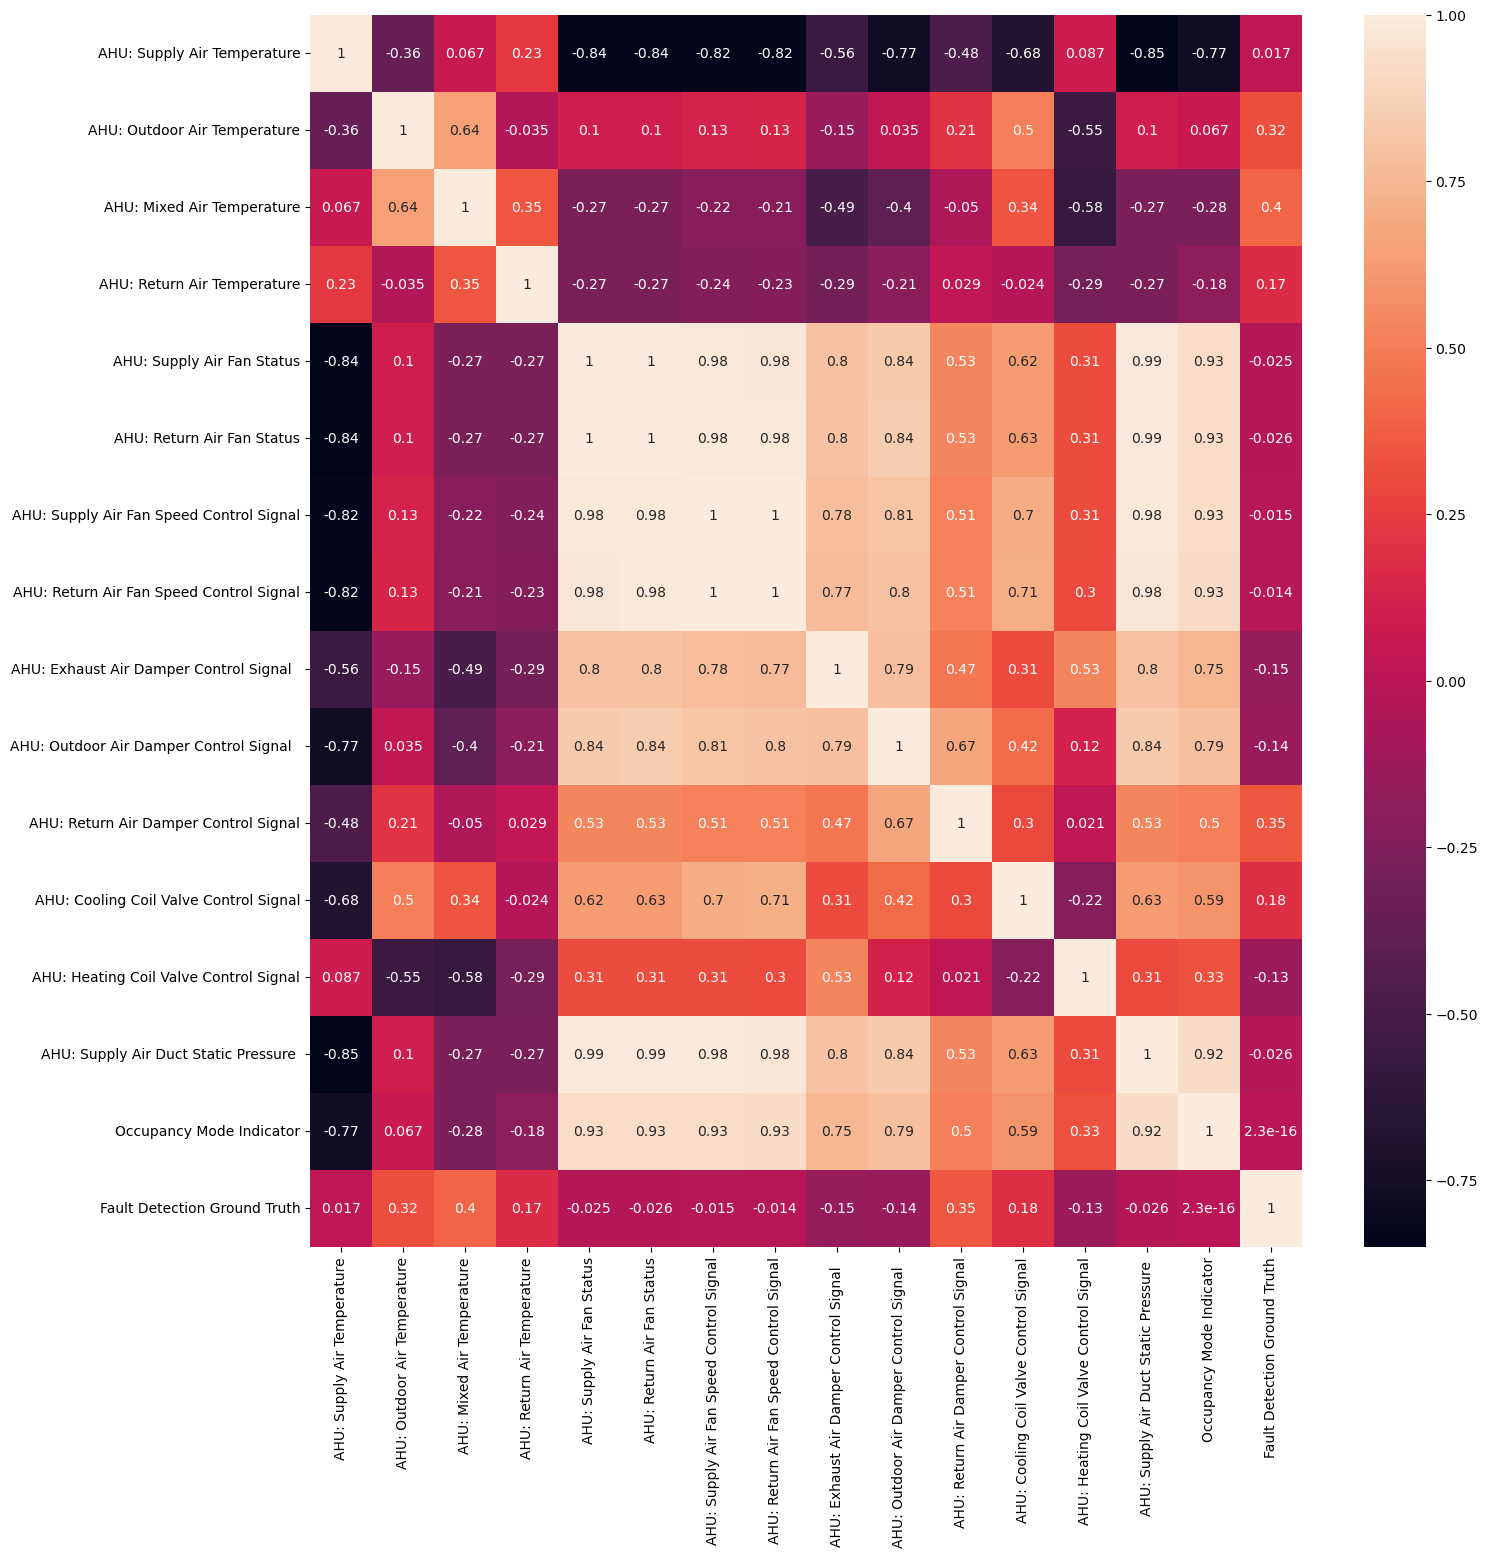

In [74]:
plt.figure(figsize=(16,16))
sns.heatmap(data_exp.corr(), annot=True)

Upon reviewing the dataset, it becomes evident that five columns—namely, "AHU: Supply Air Fan Status," "AHU: Return Air Fan Status," "AHU: Supply Air Fan Speed Control Signal," "AHU: Return Air Fan Speed Control Signal," and "AHU: Supply Air Duct Static Pressure"—exhibit significant correlation, likely attributed to the control sequence. To mitigate multicollinearity, it is rational to retain only one of these columns.

Notably, the dataset description indicates that fans are deactivated during unoccupied mode. Additionally, a strong correlation is evident between the occupancy mode indicator and the supply air fan status. Consequently, it is reasonable to omit the occupancy mode indicator column as well.

In [75]:
data_exp.drop(['AHU: Return Air Fan Status', 'AHU: Supply Air Fan Speed Control Signal','AHU: Return Air Fan Speed Control Signal',
                 'AHU: Supply Air Duct Static Pressure ', 'Occupancy Mode Indicator'], axis=1, inplace=True)

<AxesSubplot:>

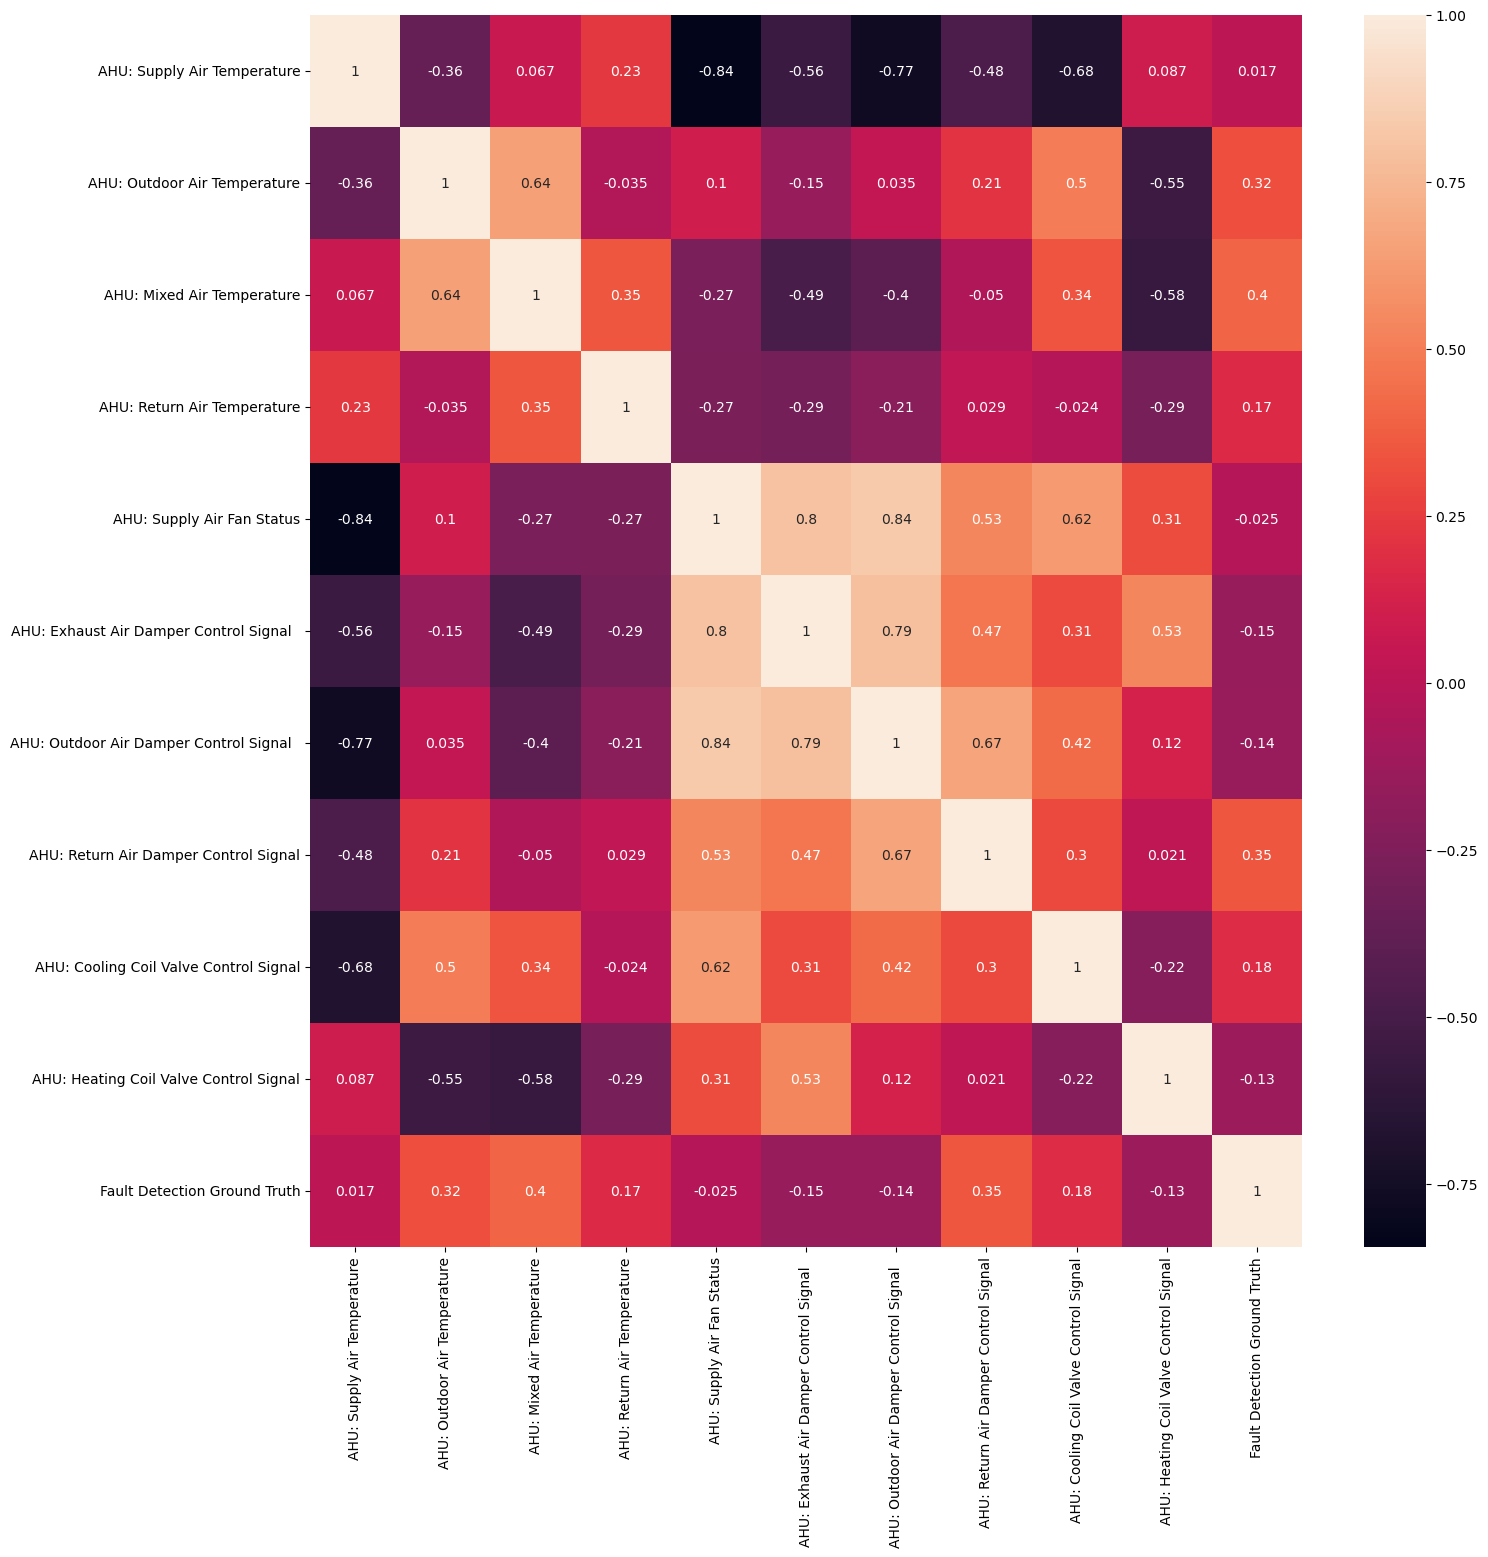

In [76]:
plt.figure(figsize=(16,16))
sns.heatmap(data_exp.corr(), annot=True)

The dataset appears to be ready for the subsequent model-building phase. In the heatmap above correlations involving the "Fault Detection Ground Truth" column and several other columns is visible. This correlation indicates that the "Fault Detection Ground Truth" column is well-suited as a target for a classification algorithm.

## Model building

### Feature and target data preparation

In [77]:
X_exp = data_exp.drop(['Datetime','Fault Detection Ground Truth'], axis=1)

In [78]:
y_exp = data_exp['Fault Detection Ground Truth']

In [79]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, test_size=0.1, shuffle=True)

### Classification model training

In [80]:
models_exp, Acc_exp = train_evaluate_classification_models(X_train_exp, X_test_exp, y_train_exp, y_test_exp, classifiers)

Learning rate set to 0.036577
0:	learn: 0.5814994	total: 167ms	remaining: 2m 46s
1:	learn: 0.4852657	total: 179ms	remaining: 1m 29s
2:	learn: 0.4062913	total: 194ms	remaining: 1m 4s
3:	learn: 0.3448724	total: 207ms	remaining: 51.5s
4:	learn: 0.2932758	total: 222ms	remaining: 44.2s
5:	learn: 0.2503437	total: 237ms	remaining: 39.2s
6:	learn: 0.2169247	total: 250ms	remaining: 35.5s
7:	learn: 0.1889626	total: 263ms	remaining: 32.6s
8:	learn: 0.1682111	total: 274ms	remaining: 30.1s
9:	learn: 0.1495417	total: 287ms	remaining: 28.4s
10:	learn: 0.1352838	total: 302ms	remaining: 27.1s
11:	learn: 0.1228786	total: 314ms	remaining: 25.8s
12:	learn: 0.1154790	total: 326ms	remaining: 24.7s
13:	learn: 0.1071281	total: 340ms	remaining: 24s
14:	learn: 0.1005814	total: 354ms	remaining: 23.3s
15:	learn: 0.0947399	total: 365ms	remaining: 22.4s
16:	learn: 0.0931438	total: 377ms	remaining: 21.8s
17:	learn: 0.0889030	total: 390ms	remaining: 21.3s
18:	learn: 0.0860282	total: 404ms	remaining: 20.9s
19:	learn: 

166:	learn: 0.0105887	total: 2.54s	remaining: 12.7s
167:	learn: 0.0105392	total: 2.55s	remaining: 12.6s
168:	learn: 0.0104501	total: 2.57s	remaining: 12.6s
169:	learn: 0.0103267	total: 2.58s	remaining: 12.6s
170:	learn: 0.0102649	total: 2.6s	remaining: 12.6s
171:	learn: 0.0102246	total: 2.62s	remaining: 12.6s
172:	learn: 0.0101815	total: 2.63s	remaining: 12.6s
173:	learn: 0.0101384	total: 2.64s	remaining: 12.5s
174:	learn: 0.0100812	total: 2.65s	remaining: 12.5s
175:	learn: 0.0099666	total: 2.67s	remaining: 12.5s
176:	learn: 0.0099132	total: 2.68s	remaining: 12.5s
177:	learn: 0.0098236	total: 2.7s	remaining: 12.5s
178:	learn: 0.0097875	total: 2.72s	remaining: 12.5s
179:	learn: 0.0097297	total: 2.74s	remaining: 12.5s
180:	learn: 0.0096260	total: 2.75s	remaining: 12.5s
181:	learn: 0.0095041	total: 2.77s	remaining: 12.5s
182:	learn: 0.0094279	total: 2.79s	remaining: 12.5s
183:	learn: 0.0093302	total: 2.8s	remaining: 12.4s
184:	learn: 0.0093277	total: 2.82s	remaining: 12.4s
185:	learn: 0.0

327:	learn: 0.0043911	total: 5.09s	remaining: 10.4s
328:	learn: 0.0043744	total: 5.11s	remaining: 10.4s
329:	learn: 0.0043613	total: 5.12s	remaining: 10.4s
330:	learn: 0.0043467	total: 5.13s	remaining: 10.4s
331:	learn: 0.0043162	total: 5.14s	remaining: 10.3s
332:	learn: 0.0043097	total: 5.16s	remaining: 10.3s
333:	learn: 0.0042975	total: 5.17s	remaining: 10.3s
334:	learn: 0.0042875	total: 5.18s	remaining: 10.3s
335:	learn: 0.0042654	total: 5.19s	remaining: 10.3s
336:	learn: 0.0042413	total: 5.2s	remaining: 10.2s
337:	learn: 0.0042108	total: 5.21s	remaining: 10.2s
338:	learn: 0.0041937	total: 5.23s	remaining: 10.2s
339:	learn: 0.0041862	total: 5.24s	remaining: 10.2s
340:	learn: 0.0041643	total: 5.25s	remaining: 10.2s
341:	learn: 0.0041529	total: 5.26s	remaining: 10.1s
342:	learn: 0.0041326	total: 5.28s	remaining: 10.1s
343:	learn: 0.0041173	total: 5.29s	remaining: 10.1s
344:	learn: 0.0041068	total: 5.3s	remaining: 10.1s
345:	learn: 0.0040970	total: 5.31s	remaining: 10s
346:	learn: 0.00

494:	learn: 0.0026010	total: 7.39s	remaining: 7.54s
495:	learn: 0.0025895	total: 7.4s	remaining: 7.52s
496:	learn: 0.0025815	total: 7.42s	remaining: 7.51s
497:	learn: 0.0025772	total: 7.43s	remaining: 7.49s
498:	learn: 0.0025717	total: 7.44s	remaining: 7.47s
499:	learn: 0.0025682	total: 7.46s	remaining: 7.46s
500:	learn: 0.0025658	total: 7.47s	remaining: 7.44s
501:	learn: 0.0025600	total: 7.48s	remaining: 7.42s
502:	learn: 0.0025548	total: 7.49s	remaining: 7.4s
503:	learn: 0.0025525	total: 7.51s	remaining: 7.39s
504:	learn: 0.0025474	total: 7.52s	remaining: 7.37s
505:	learn: 0.0025444	total: 7.54s	remaining: 7.36s
506:	learn: 0.0025404	total: 7.55s	remaining: 7.34s
507:	learn: 0.0025355	total: 7.57s	remaining: 7.33s
508:	learn: 0.0025301	total: 7.59s	remaining: 7.32s
509:	learn: 0.0025202	total: 7.6s	remaining: 7.3s
510:	learn: 0.0025102	total: 7.62s	remaining: 7.29s
511:	learn: 0.0024996	total: 7.63s	remaining: 7.27s
512:	learn: 0.0024922	total: 7.64s	remaining: 7.26s
513:	learn: 0.00

659:	learn: 0.0017996	total: 9.5s	remaining: 4.89s
660:	learn: 0.0017983	total: 9.51s	remaining: 4.88s
661:	learn: 0.0017941	total: 9.52s	remaining: 4.86s
662:	learn: 0.0017923	total: 9.54s	remaining: 4.85s
663:	learn: 0.0017892	total: 9.55s	remaining: 4.83s
664:	learn: 0.0017844	total: 9.56s	remaining: 4.81s
665:	learn: 0.0017831	total: 9.57s	remaining: 4.8s
666:	learn: 0.0017816	total: 9.58s	remaining: 4.78s
667:	learn: 0.0017791	total: 9.59s	remaining: 4.77s
668:	learn: 0.0017761	total: 9.6s	remaining: 4.75s
669:	learn: 0.0017730	total: 9.62s	remaining: 4.74s
670:	learn: 0.0017698	total: 9.63s	remaining: 4.72s
671:	learn: 0.0017670	total: 9.66s	remaining: 4.71s
672:	learn: 0.0017662	total: 9.68s	remaining: 4.7s
673:	learn: 0.0017662	total: 9.69s	remaining: 4.69s
674:	learn: 0.0017662	total: 9.7s	remaining: 4.67s
675:	learn: 0.0017661	total: 9.72s	remaining: 4.66s
676:	learn: 0.0017662	total: 9.73s	remaining: 4.64s
677:	learn: 0.0017662	total: 9.75s	remaining: 4.63s
678:	learn: 0.001

821:	learn: 0.0017181	total: 11.2s	remaining: 2.42s
822:	learn: 0.0017181	total: 11.2s	remaining: 2.4s
823:	learn: 0.0017181	total: 11.2s	remaining: 2.39s
824:	learn: 0.0017181	total: 11.2s	remaining: 2.37s
825:	learn: 0.0017181	total: 11.2s	remaining: 2.36s
826:	learn: 0.0017181	total: 11.2s	remaining: 2.34s
827:	learn: 0.0017181	total: 11.2s	remaining: 2.33s
828:	learn: 0.0017181	total: 11.2s	remaining: 2.32s
829:	learn: 0.0017181	total: 11.2s	remaining: 2.3s
830:	learn: 0.0017181	total: 11.3s	remaining: 2.29s
831:	learn: 0.0017181	total: 11.3s	remaining: 2.28s
832:	learn: 0.0017180	total: 11.3s	remaining: 2.26s
833:	learn: 0.0017180	total: 11.3s	remaining: 2.25s
834:	learn: 0.0017180	total: 11.3s	remaining: 2.23s
835:	learn: 0.0017180	total: 11.3s	remaining: 2.22s
836:	learn: 0.0017180	total: 11.3s	remaining: 2.21s
837:	learn: 0.0017180	total: 11.3s	remaining: 2.19s
838:	learn: 0.0017180	total: 11.3s	remaining: 2.18s
839:	learn: 0.0017180	total: 11.4s	remaining: 2.16s
840:	learn: 0.

997:	learn: 0.0017175	total: 12.8s	remaining: 25.7ms
998:	learn: 0.0017175	total: 12.8s	remaining: 12.8ms
999:	learn: 0.0017175	total: 12.8s	remaining: 0us


### Models evaluation

In [81]:
print(Acc_exp)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.997119       0.994444         0.990374   
1               MLPClassifier        0.974897       0.978704         0.850979   
2          AdaBoostClassifier        0.992438       0.993056         0.973035   
3  GradientBoostingClassifier        0.994547       0.996759         0.968480   
4          CatBoostClassifier        1.000000       1.000000         1.000000   
5               XGBClassifier        1.000000       1.000000         1.000000   
6           BaggingClassifier        0.999897       1.000000         1.000000   
7      RandomForestClassifier        1.000000       1.000000         1.000000   
8      DecisionTreeClassifier        1.000000       0.999074         1.000000   
9          LogisticRegression        0.923302       0.931019         0.713027   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.988930      0.988091     0.967

The outcomes highlight the remarkable performance of most models in this task, even without balancing or fine-tuning efforts. Interestingly, even the Logistic Regression model exhibits relatively strong performance. This trend suggests that the relationships between features and target data are easily recognizable, and the dataset is well-prepared. This implies that utilizing machine learning models for detecting such faults is likely to be straightforward and practical, as long as we have high quality data.

Creating such a system, however, would necessitate a sequence of functional tests, and good procedures to produce such high quality data, and this process could be costly. However, the ultimate result would be an exceptionally effective tool for fault detection, a solution with the potential of substantial benefits. These benefits could notably outweigh the implementation costs, particularly when contrasted with the financial consequences of overlooked faults or inefficiencies in the building management system.

### Feature importances

<BarContainer object of 10 artists>

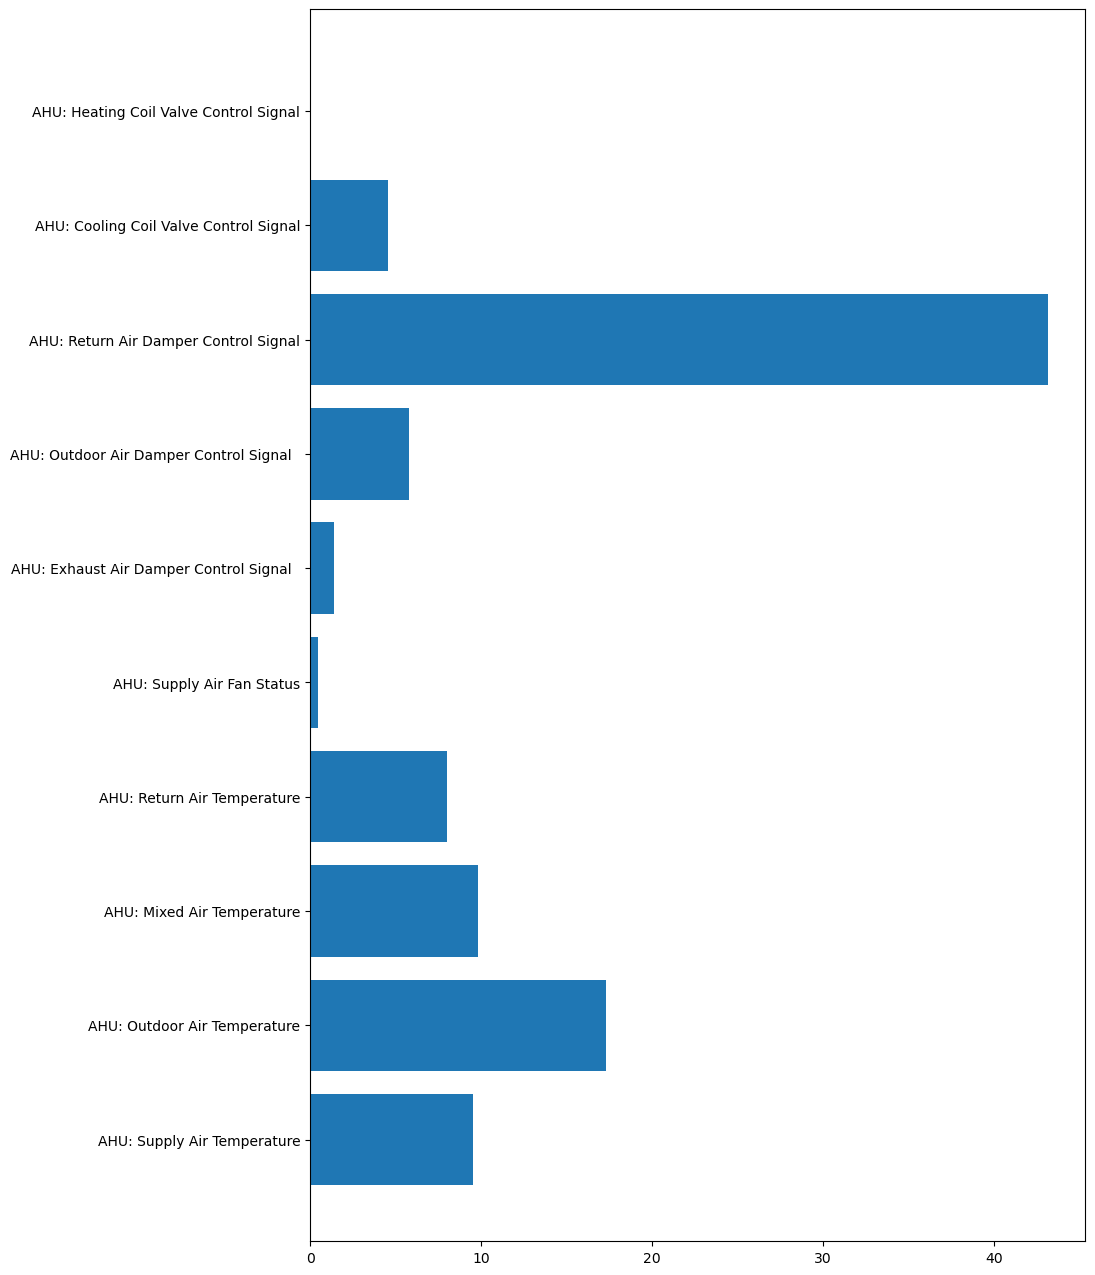

In [82]:
plt.figure(figsize=(10,16))
plt.barh(X_exp.columns, models_exp[4].get_feature_importance())

An intriguing observation emerges from the above graph: the heating coil valve signal holds minimal importance in detecting faults associated with it. This unexpected finding could imply that the faulty element's behavior doesn't inherently offer direct clues about its malfunction. Maybe the weather conditions didn't require much work from the heater. Instead, fault indications likely arise from the atypical behaviors of other components. For instance, the cold valve signal carries more significance, potentially because a faulty heating valve might lead to increased demand for cooling, intensifying the cold valve's activity.

This insight underscores the complex interplay between system components and their fault indicators. It emphasizes the need to consider not only the individual behavior of components but also their collective responses in identifying anomalies and failures. It also highlights the usefulness of machine learning tools.

# Simulated dataset

## Data exploration and feature engineering

In [83]:
raw_data_sim.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
3151,8/30/2007 4:31,86.54,55,58.31,81.77,82.00,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,1.08,0,1
7394,9/2/2007 3:14,69.48,55,63.40,70.79,71.04,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,3.59,0,1
19071,8/27/2008 5:51,77.83,55,73.64,73.64,60.12,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.01,0,0
7039,9/1/2007 21:19,48.63,55,69.93,69.93,66.96,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.01,0,1
39,8/28/2007 0:39,80.21,55,79.80,76.63,76.60,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,1.08,0,1


In [84]:
raw_data_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37440 entries, 0 to 37439
Data columns (total 19 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Datetime                                        37440 non-null  object 
 1   AHU: Supply Air Temperature                     37440 non-null  float64
 2   AHU: Supply Air Temperature Set Point           37440 non-null  int64  
 3   AHU: Outdoor Air Temperature                    37440 non-null  float64
 4   AHU: Mixed Air Temperature                      37440 non-null  float64
 5   AHU: Return Air Temperature                     37440 non-null  float64
 6   AHU: Supply Air Fan Status                      37440 non-null  int64  
 7   AHU: Return Air Fan Status                      37440 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal        37440 non-null  float64
 9   AHU: Return Air Fan Speed Control Signa

It appears that the dataset is free from any major cleaning requirements, except for the modification of the "Datetime" column's datatype to datetime. 

In [85]:
raw_data_sim['Datetime'] = pd.to_datetime(raw_data_sim['Datetime'])

In [86]:
# Preparing datasets for Boxplot visualisation
temp_col = [col for col in raw_data_sim.columns if "Temp" in col]
control_col = [col for col in raw_data_sim.columns if "Control" in col]
pressure_col = [col for col in raw_data_sim.columns if "Pressure" in col]
temp_data = raw_data_exp[temp_col].melt(var_name='Temperature column', value_name='Temperature in Fahrenheit')
control_data = raw_data_exp[control_col].melt(var_name='Control value column', value_name='0-1')
pressure_data = raw_data_exp[pressure_col].melt(var_name='Pressure column', value_name='Pressure in Psi')

[Text(0, 0, 'AHU: Supply Air Temperature'),
 Text(1, 0, 'AHU: Supply Air Temperature Set Point'),
 Text(2, 0, 'AHU: Outdoor Air Temperature'),
 Text(3, 0, 'AHU: Mixed Air Temperature'),
 Text(4, 0, 'AHU: Return Air Temperature')]

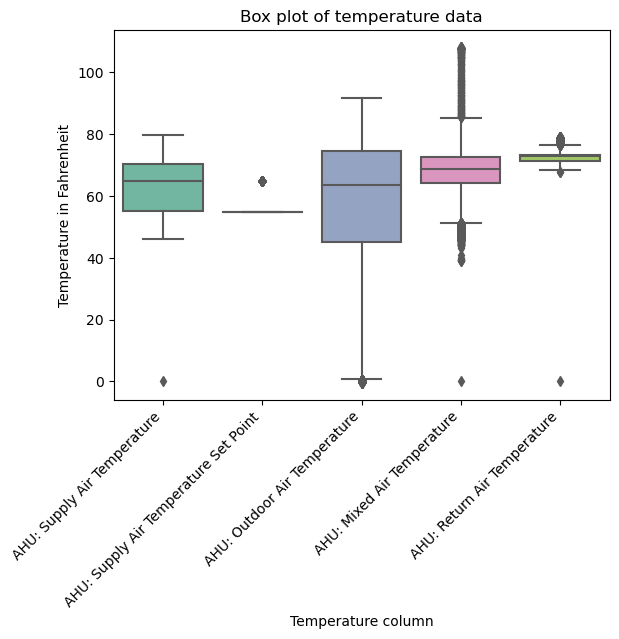

In [87]:
ax = sns.boxplot(x='Temperature column', y='Temperature in Fahrenheit', data=temp_data, palette="Set2")
plt.title("Box plot of temperature data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Fan Speed Control Signal'),
 Text(1, 0, 'AHU: Return Air Fan Speed Control Signal'),
 Text(2, 0, 'AHU: Exhaust Air Damper Control Signal  '),
 Text(3, 0, 'AHU: Outdoor Air Damper Control Signal  '),
 Text(4, 0, 'AHU: Return Air Damper Control Signal'),
 Text(5, 0, 'AHU: Cooling Coil Valve Control Signal'),
 Text(6, 0, 'AHU: Heating Coil Valve Control Signal')]

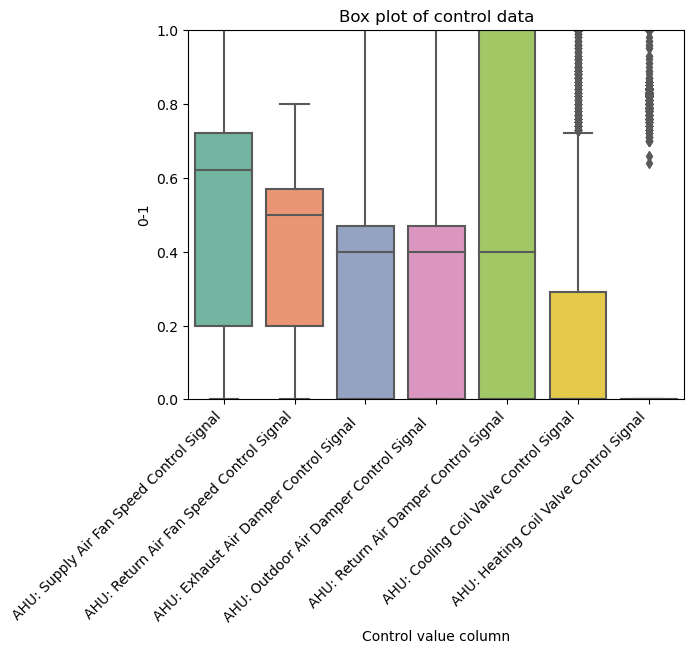

In [88]:
ax = sns.boxplot(x='Control value column', y='0-1', data=control_data, palette="Set2")
plt.title("Box plot of control data")
plt.ylim(0,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Duct Static Pressure Set Point'),
 Text(1, 0, 'AHU: Supply Air Duct Static Pressure ')]

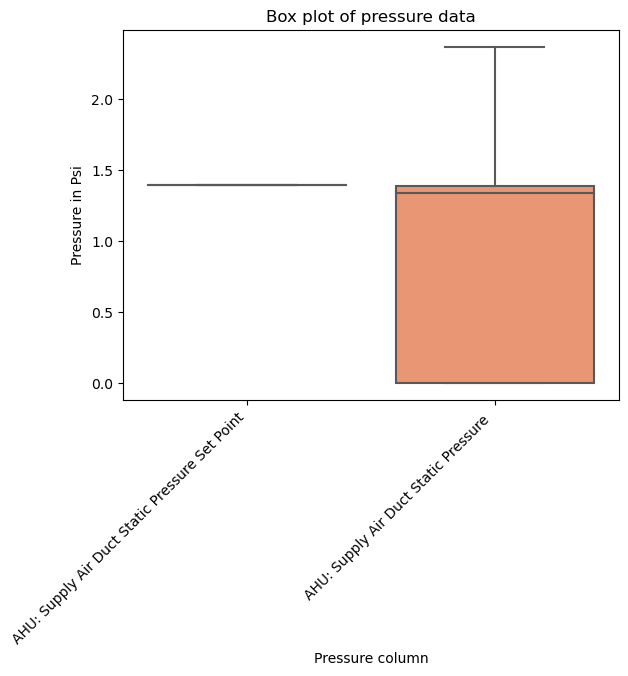

In [89]:
ax = sns.boxplot(x='Pressure column', y='Pressure in Psi', data=pressure_data, palette="Set2")
plt.title("Box plot of pressure data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [90]:
raw_data_sim.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
count,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,3.744000e+04,37440.000000,37440.000000,37440.000000
mean,63.237180,55.662126,64.445303,66.916624,68.218243,0.653846,0.500000,0.568830,0.362148,0.286949,0.286949,0.713051,0.203983,0.050786,1.400000e+00,1.343421,0.500000,0.500000
std,11.940915,2.486567,18.987496,14.653489,7.483220,0.475749,0.500007,0.430636,0.387902,0.340170,0.340170,0.340170,0.286489,0.206367,9.201651e-13,1.409967,0.500007,0.500007
min,23.850000,55.000000,1.540000,1.540000,50.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000e+00,-0.490000,0.000000,0.000000
25%,54.980000,55.000000,60.677500,63.360000,60.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,1.400000e+00,0.010000,0.000000,0.000000
50%,60.805000,55.000000,68.470000,71.300000,71.180000,1.000000,0.500000,0.710000,0.240000,0.400000,0.400000,0.600000,0.000000,0.000000,1.400000e+00,1.350000,0.500000,0.500000
75%,71.850000,55.000000,75.582500,74.270000,72.110000,1.000000,1.000000,1.000000,0.580000,0.400000,0.400000,1.000000,0.470000,0.000000,1.400000e+00,1.780000,1.000000,1.000000
max,107.940000,65.000000,91.850000,90.300000,90.870000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.400000e+00,5.010000,1.000000,1.000000


In [91]:
# Making copy of dataset for further data transformation
data_sim = raw_data_sim.copy()

AHU: Supply Air Duct Static Pressure Set Point and AHU: Supply Air Temperature Set Point column has nearly constant values so it should be excluded from the dataset.

In [92]:
data_sim.drop(['AHU: Supply Air Duct Static Pressure Set Point','AHU: Supply Air Temperature Set Point'], axis=1, inplace=True)

<AxesSubplot:>

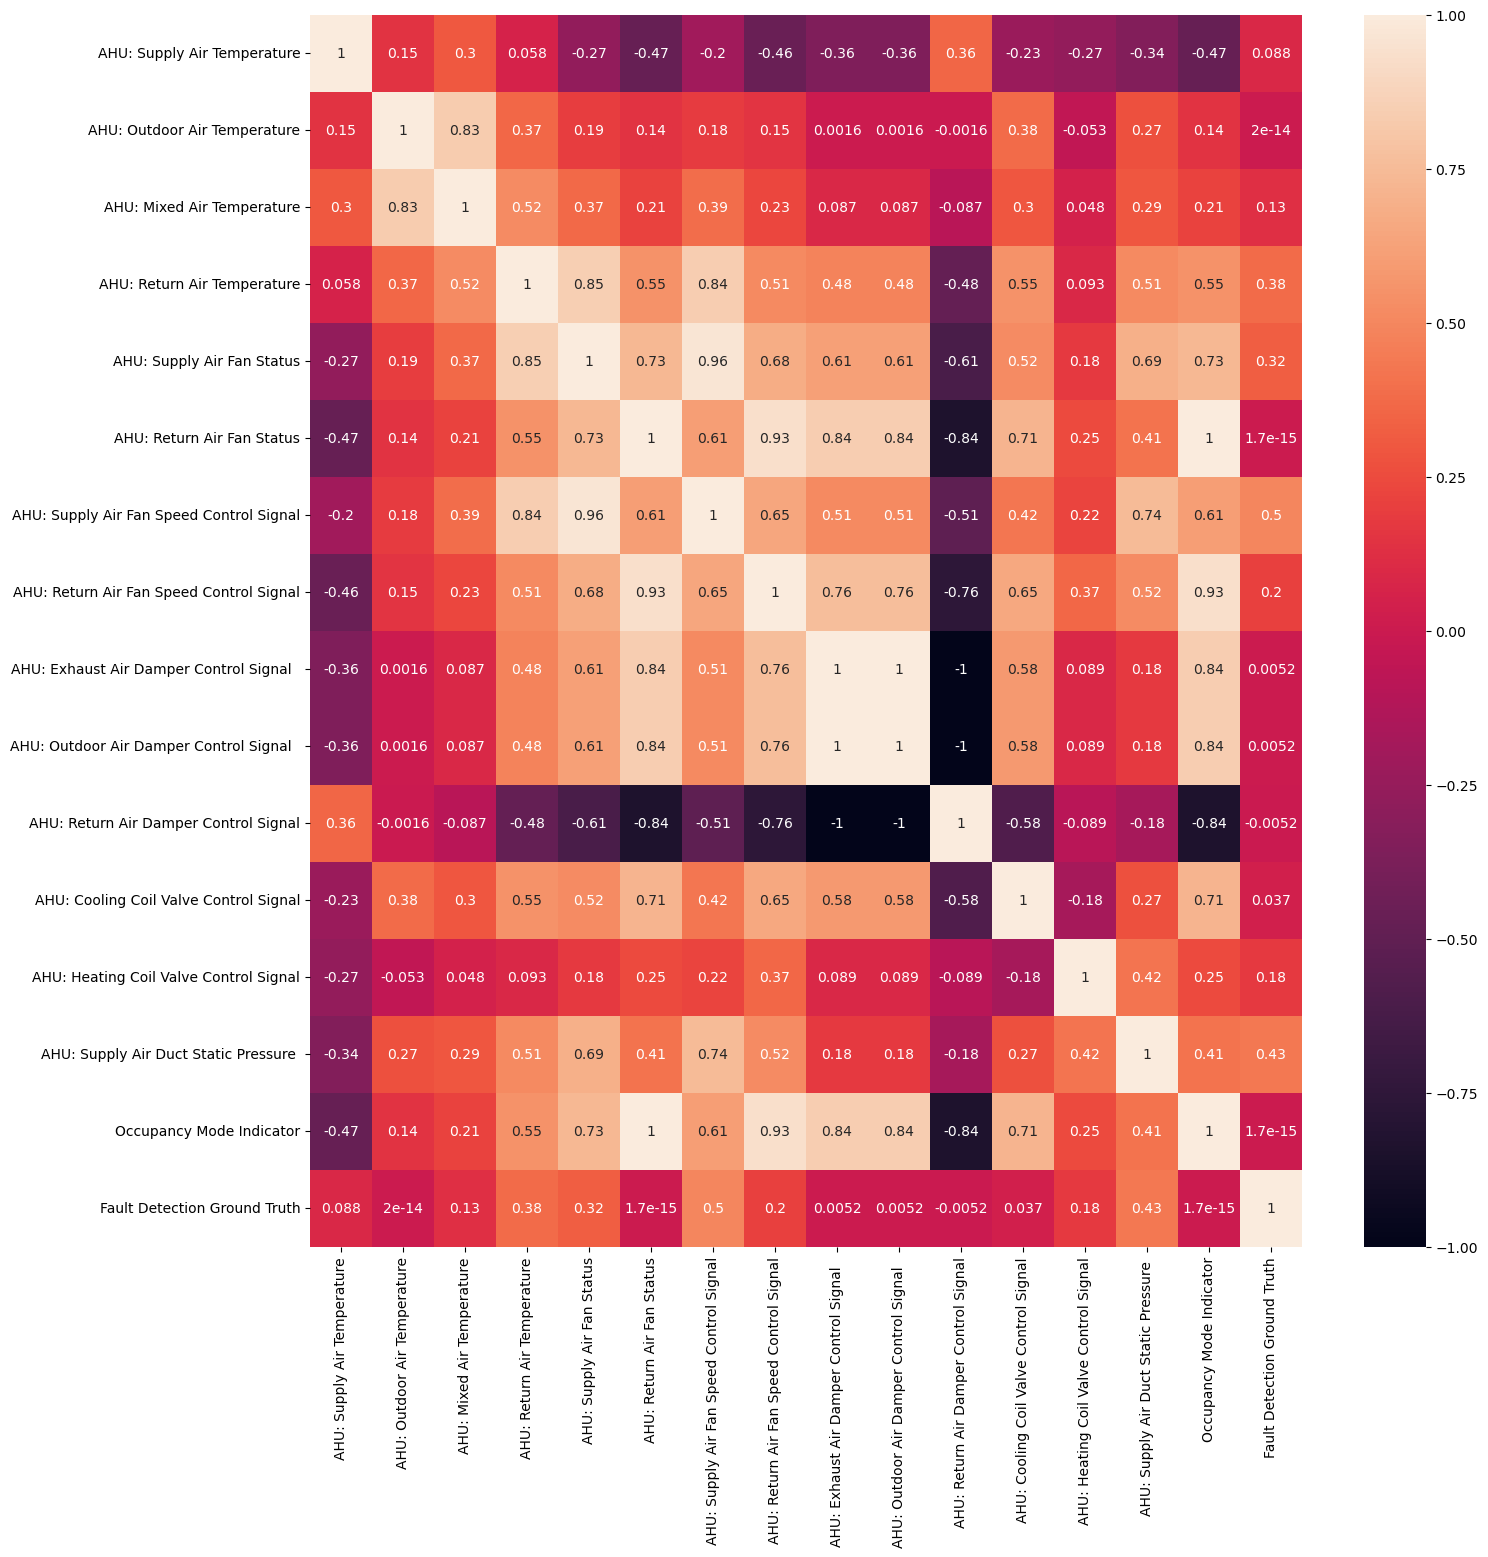

In [93]:
plt.figure(figsize=(16,16))
sns.heatmap(data_sim.corr(), annot=True)

The "AHU: Supply Air Fan Status" and "Occupancy Mode Indicator" columns exhibit complete correlation, rendering it unnecessary to retain both. Therefore, only the "AHU: Supply Air Fan Status" column will be retained.

Among the columns "AHU: Exhaust Air Damper Control Signal," "AHU: Outdoor Air Damper Control Signal," and "AHU: Return Air Damper Control Signal," a 100% correlation is also evident, necessitating the preservation of only one. Hence, the "AHU: Exhaust Air Damper Control Signal" column will be retained.

These modifications align with the objective of refining the dataset for analysis and modeling by removing redundant and correlated features.

In [94]:
data_sim.drop(['Occupancy Mode Indicator','AHU: Outdoor Air Damper Control Signal  ','AHU: Return Air Damper Control Signal'], axis=1,inplace=True)

<AxesSubplot:>

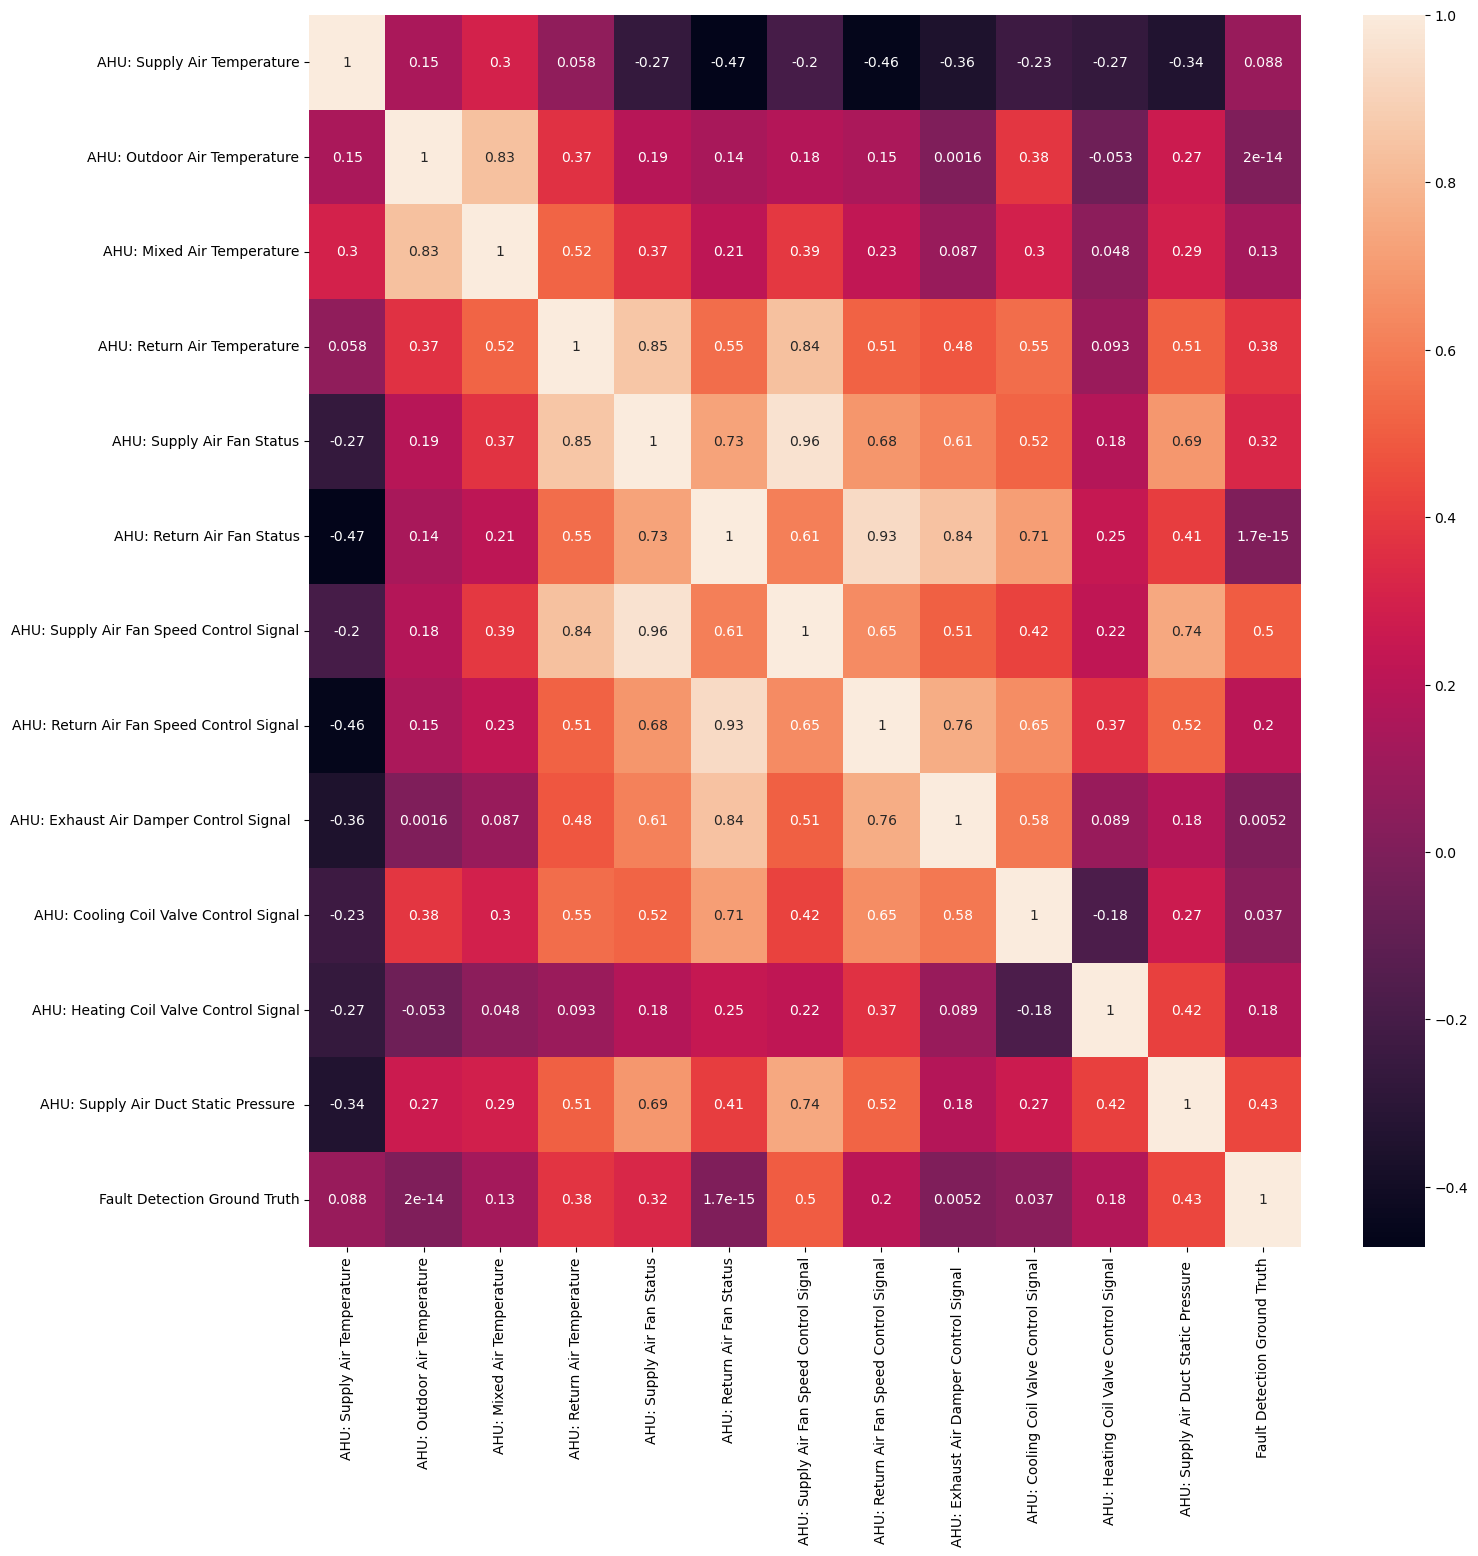

In [95]:
plt.figure(figsize=(16,16))
sns.heatmap(data_sim.corr(), annot=True)

The dataset appears to be well-prepared for the subsequent phase of model building. The "Fault Detection Ground Truth" column exhibits correlations with certain other columns. However, upon closer inspection of the dataset description, it becomes evident that this column encompasses a diverse array of fault types. Taking that into consideration it holds greater value to discern not only the presence of a fault but also the specific fault type. Consequently, three distinct target columns will be prepared to do this. This alteration enables a more nuanced and informative modeling approach.

In [96]:
def convert_date(date_str):
    return pd.to_datetime(date_str, format='%m/%d/%Y')

In [97]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('2/12/2008'), 
                  convert_date('5/7/2008'), 
                  convert_date('5/8/2008'), 
                  convert_date('9/5/2007'), 
                  convert_date('9/6/2007')]
heat_vlv_fault_dates = [convert_date('8/28/2007'), 
                        convert_date('8/29/2007'), 
                        convert_date('8/30/2007')]
cool_vlv_fault_dates = [convert_date('5/6/2008'), 
                        convert_date('8/31/2007'), 
                        convert_date('5/15/2008'),
                        convert_date('9/1/2007'),
                        convert_date('9/2/2007')]

In [98]:
# Creating and filling fault column with values according to the dates given earlier.
data_sim['OA_fault'] = 0
data_sim['heat_vlv_fault'] = 0
data_sim['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_sim.loc[data_sim['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_sim.loc[data_sim['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_sim.loc[data_sim['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [99]:
X_sim = data_sim.drop(['Datetime','Fault Detection Ground Truth','OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [100]:
y_oa = data_sim['OA_fault']
y_heat = data_sim['heat_vlv_fault']
y_cool = data_sim['cool_vlv_fault']

In [101]:
X_train_oa, X_test_oa, y_train_oa, y_test_oa = train_test_split(X_sim, y_oa, test_size=0.1, shuffle=True)
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(X_sim, y_heat, test_size=0.1, shuffle=True)
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(X_sim, y_cool, test_size=0.1, shuffle=True)

### Classification model training

In [102]:
models_oa, Acc_oa = train_evaluate_classification_models(X_train_oa, X_test_oa, y_train_oa, y_test_oa, classifiers)
models_heat, Acc_heat = train_evaluate_classification_models(X_train_heat, X_test_heat, y_train_heat, y_test_heat, classifiers)
models_cool, Acc_cool = train_evaluate_classification_models(X_train_cool, X_test_cool, y_train_cool, y_test_cool, classifiers)

Learning rate set to 0.04626
0:	learn: 0.6143219	total: 14.3ms	remaining: 14.3s
1:	learn: 0.5538207	total: 27.3ms	remaining: 13.6s
2:	learn: 0.5087697	total: 38.9ms	remaining: 12.9s
3:	learn: 0.4642589	total: 53.4ms	remaining: 13.3s
4:	learn: 0.4107965	total: 66.1ms	remaining: 13.2s
5:	learn: 0.3805403	total: 77.6ms	remaining: 12.8s
6:	learn: 0.3451550	total: 89.7ms	remaining: 12.7s
7:	learn: 0.3181588	total: 102ms	remaining: 12.6s
8:	learn: 0.2946218	total: 118ms	remaining: 13s
9:	learn: 0.2812428	total: 131ms	remaining: 12.9s
10:	learn: 0.2632685	total: 143ms	remaining: 12.8s
11:	learn: 0.2455425	total: 154ms	remaining: 12.7s
12:	learn: 0.2372699	total: 167ms	remaining: 12.6s
13:	learn: 0.2239811	total: 184ms	remaining: 13s
14:	learn: 0.2177580	total: 196ms	remaining: 12.8s
15:	learn: 0.2094485	total: 210ms	remaining: 12.9s
16:	learn: 0.2023662	total: 226ms	remaining: 13s
17:	learn: 0.1965572	total: 241ms	remaining: 13.2s
18:	learn: 0.1916302	total: 262ms	remaining: 13.5s
19:	learn: 

160:	learn: 0.0489402	total: 2.13s	remaining: 11.1s
161:	learn: 0.0486987	total: 2.14s	remaining: 11.1s
162:	learn: 0.0485118	total: 2.15s	remaining: 11.1s
163:	learn: 0.0482940	total: 2.17s	remaining: 11s
164:	learn: 0.0481375	total: 2.18s	remaining: 11s
165:	learn: 0.0479950	total: 2.19s	remaining: 11s
166:	learn: 0.0479294	total: 2.2s	remaining: 11s
167:	learn: 0.0478018	total: 2.22s	remaining: 11s
168:	learn: 0.0476894	total: 2.23s	remaining: 11s
169:	learn: 0.0476210	total: 2.25s	remaining: 11s
170:	learn: 0.0475154	total: 2.26s	remaining: 11s
171:	learn: 0.0474414	total: 2.28s	remaining: 11s
172:	learn: 0.0473415	total: 2.29s	remaining: 11s
173:	learn: 0.0471813	total: 2.31s	remaining: 11s
174:	learn: 0.0470779	total: 2.34s	remaining: 11s
175:	learn: 0.0468727	total: 2.36s	remaining: 11s
176:	learn: 0.0467484	total: 2.37s	remaining: 11s
177:	learn: 0.0466521	total: 2.38s	remaining: 11s
178:	learn: 0.0465774	total: 2.4s	remaining: 11s
179:	learn: 0.0463927	total: 2.41s	remaining: 

322:	learn: 0.0360585	total: 4.43s	remaining: 9.3s
323:	learn: 0.0360201	total: 4.45s	remaining: 9.29s
324:	learn: 0.0359575	total: 4.47s	remaining: 9.28s
325:	learn: 0.0359077	total: 4.48s	remaining: 9.27s
326:	learn: 0.0358952	total: 4.5s	remaining: 9.25s
327:	learn: 0.0358372	total: 4.51s	remaining: 9.23s
328:	learn: 0.0357821	total: 4.52s	remaining: 9.22s
329:	learn: 0.0357242	total: 4.53s	remaining: 9.21s
330:	learn: 0.0357087	total: 4.55s	remaining: 9.19s
331:	learn: 0.0356585	total: 4.56s	remaining: 9.17s
332:	learn: 0.0356131	total: 4.57s	remaining: 9.15s
333:	learn: 0.0355633	total: 4.58s	remaining: 9.13s
334:	learn: 0.0355302	total: 4.59s	remaining: 9.12s
335:	learn: 0.0354910	total: 4.61s	remaining: 9.1s
336:	learn: 0.0354878	total: 4.62s	remaining: 9.08s
337:	learn: 0.0354334	total: 4.63s	remaining: 9.07s
338:	learn: 0.0354047	total: 4.64s	remaining: 9.05s
339:	learn: 0.0353904	total: 4.66s	remaining: 9.04s
340:	learn: 0.0353594	total: 4.67s	remaining: 9.02s
341:	learn: 0.0

484:	learn: 0.0322338	total: 6.54s	remaining: 6.94s
485:	learn: 0.0322024	total: 6.55s	remaining: 6.93s
486:	learn: 0.0321562	total: 6.57s	remaining: 6.92s
487:	learn: 0.0321393	total: 6.58s	remaining: 6.91s
488:	learn: 0.0321371	total: 6.59s	remaining: 6.89s
489:	learn: 0.0320909	total: 6.61s	remaining: 6.88s
490:	learn: 0.0320625	total: 6.62s	remaining: 6.86s
491:	learn: 0.0320376	total: 6.63s	remaining: 6.85s
492:	learn: 0.0320360	total: 6.64s	remaining: 6.83s
493:	learn: 0.0320161	total: 6.65s	remaining: 6.82s
494:	learn: 0.0320139	total: 6.67s	remaining: 6.8s
495:	learn: 0.0320125	total: 6.68s	remaining: 6.79s
496:	learn: 0.0319675	total: 6.69s	remaining: 6.77s
497:	learn: 0.0319291	total: 6.7s	remaining: 6.75s
498:	learn: 0.0319211	total: 6.72s	remaining: 6.74s
499:	learn: 0.0319016	total: 6.73s	remaining: 6.73s
500:	learn: 0.0318783	total: 6.74s	remaining: 6.71s
501:	learn: 0.0318454	total: 6.75s	remaining: 6.7s
502:	learn: 0.0318282	total: 6.77s	remaining: 6.69s
503:	learn: 0.0

650:	learn: 0.0302608	total: 8.66s	remaining: 4.64s
651:	learn: 0.0302516	total: 8.68s	remaining: 4.63s
652:	learn: 0.0302498	total: 8.69s	remaining: 4.62s
653:	learn: 0.0302125	total: 8.7s	remaining: 4.6s
654:	learn: 0.0302084	total: 8.71s	remaining: 4.59s
655:	learn: 0.0301948	total: 8.72s	remaining: 4.58s
656:	learn: 0.0301624	total: 8.74s	remaining: 4.56s
657:	learn: 0.0301509	total: 8.75s	remaining: 4.55s
658:	learn: 0.0301438	total: 8.76s	remaining: 4.53s
659:	learn: 0.0301361	total: 8.77s	remaining: 4.52s
660:	learn: 0.0301293	total: 8.79s	remaining: 4.51s
661:	learn: 0.0301276	total: 8.8s	remaining: 4.49s
662:	learn: 0.0301261	total: 8.81s	remaining: 4.48s
663:	learn: 0.0301193	total: 8.82s	remaining: 4.46s
664:	learn: 0.0301187	total: 8.84s	remaining: 4.45s
665:	learn: 0.0301150	total: 8.85s	remaining: 4.44s
666:	learn: 0.0301134	total: 8.86s	remaining: 4.42s
667:	learn: 0.0301058	total: 8.87s	remaining: 4.41s
668:	learn: 0.0301040	total: 8.88s	remaining: 4.39s
669:	learn: 0.0

810:	learn: 0.0295265	total: 10.5s	remaining: 2.46s
811:	learn: 0.0295208	total: 10.6s	remaining: 2.44s
812:	learn: 0.0295169	total: 10.6s	remaining: 2.43s
813:	learn: 0.0295156	total: 10.6s	remaining: 2.42s
814:	learn: 0.0295103	total: 10.6s	remaining: 2.4s
815:	learn: 0.0295103	total: 10.6s	remaining: 2.39s
816:	learn: 0.0295102	total: 10.6s	remaining: 2.38s
817:	learn: 0.0295102	total: 10.6s	remaining: 2.36s
818:	learn: 0.0295087	total: 10.6s	remaining: 2.35s
819:	learn: 0.0294998	total: 10.6s	remaining: 2.34s
820:	learn: 0.0294985	total: 10.7s	remaining: 2.32s
821:	learn: 0.0294969	total: 10.7s	remaining: 2.31s
822:	learn: 0.0294969	total: 10.7s	remaining: 2.3s
823:	learn: 0.0294969	total: 10.7s	remaining: 2.28s
824:	learn: 0.0294969	total: 10.7s	remaining: 2.27s
825:	learn: 0.0294907	total: 10.7s	remaining: 2.26s
826:	learn: 0.0294857	total: 10.7s	remaining: 2.24s
827:	learn: 0.0294786	total: 10.7s	remaining: 2.23s
828:	learn: 0.0294702	total: 10.8s	remaining: 2.22s
829:	learn: 0.

989:	learn: 0.0293174	total: 12.4s	remaining: 126ms
990:	learn: 0.0293175	total: 12.4s	remaining: 113ms
991:	learn: 0.0293174	total: 12.4s	remaining: 100ms
992:	learn: 0.0293174	total: 12.5s	remaining: 87.8ms
993:	learn: 0.0293174	total: 12.5s	remaining: 75.3ms
994:	learn: 0.0293174	total: 12.5s	remaining: 62.7ms
995:	learn: 0.0293174	total: 12.5s	remaining: 50.1ms
996:	learn: 0.0293174	total: 12.5s	remaining: 37.6ms
997:	learn: 0.0293174	total: 12.5s	remaining: 25.1ms
998:	learn: 0.0293174	total: 12.5s	remaining: 12.5ms
999:	learn: 0.0293174	total: 12.5s	remaining: 0us
Learning rate set to 0.04626
0:	learn: 0.6117884	total: 14.7ms	remaining: 14.7s
1:	learn: 0.5405684	total: 25.3ms	remaining: 12.6s
2:	learn: 0.4664152	total: 38.1ms	remaining: 12.7s
3:	learn: 0.4152574	total: 49.5ms	remaining: 12.3s
4:	learn: 0.3652387	total: 62.7ms	remaining: 12.5s
5:	learn: 0.3318271	total: 75.3ms	remaining: 12.5s
6:	learn: 0.2994525	total: 86.1ms	remaining: 12.2s
7:	learn: 0.2691434	total: 99.2ms	rem

155:	learn: 0.0229009	total: 3.01s	remaining: 16.3s
156:	learn: 0.0227540	total: 3.03s	remaining: 16.3s
157:	learn: 0.0225957	total: 3.05s	remaining: 16.3s
158:	learn: 0.0224463	total: 3.07s	remaining: 16.2s
159:	learn: 0.0223539	total: 3.09s	remaining: 16.2s
160:	learn: 0.0221820	total: 3.1s	remaining: 16.2s
161:	learn: 0.0221223	total: 3.13s	remaining: 16.2s
162:	learn: 0.0219824	total: 3.15s	remaining: 16.2s
163:	learn: 0.0217428	total: 3.17s	remaining: 16.1s
164:	learn: 0.0216624	total: 3.19s	remaining: 16.1s
165:	learn: 0.0215333	total: 3.21s	remaining: 16.1s
166:	learn: 0.0213913	total: 3.22s	remaining: 16.1s
167:	learn: 0.0212651	total: 3.24s	remaining: 16.1s
168:	learn: 0.0212457	total: 3.27s	remaining: 16.1s
169:	learn: 0.0210918	total: 3.3s	remaining: 16.1s
170:	learn: 0.0209531	total: 3.33s	remaining: 16.1s
171:	learn: 0.0207151	total: 3.35s	remaining: 16.1s
172:	learn: 0.0205937	total: 3.37s	remaining: 16.1s
173:	learn: 0.0204459	total: 3.38s	remaining: 16.1s
174:	learn: 0.

317:	learn: 0.0113458	total: 5.53s	remaining: 11.9s
318:	learn: 0.0113159	total: 5.55s	remaining: 11.8s
319:	learn: 0.0112899	total: 5.56s	remaining: 11.8s
320:	learn: 0.0112393	total: 5.57s	remaining: 11.8s
321:	learn: 0.0112206	total: 5.58s	remaining: 11.8s
322:	learn: 0.0112037	total: 5.59s	remaining: 11.7s
323:	learn: 0.0111997	total: 5.61s	remaining: 11.7s
324:	learn: 0.0111584	total: 5.62s	remaining: 11.7s
325:	learn: 0.0111343	total: 5.63s	remaining: 11.6s
326:	learn: 0.0110937	total: 5.65s	remaining: 11.6s
327:	learn: 0.0110872	total: 5.66s	remaining: 11.6s
328:	learn: 0.0110352	total: 5.68s	remaining: 11.6s
329:	learn: 0.0110072	total: 5.69s	remaining: 11.6s
330:	learn: 0.0109783	total: 5.71s	remaining: 11.5s
331:	learn: 0.0109540	total: 5.72s	remaining: 11.5s
332:	learn: 0.0108974	total: 5.74s	remaining: 11.5s
333:	learn: 0.0108736	total: 5.76s	remaining: 11.5s
334:	learn: 0.0108589	total: 5.78s	remaining: 11.5s
335:	learn: 0.0108229	total: 5.79s	remaining: 11.4s
336:	learn: 

484:	learn: 0.0076679	total: 7.88s	remaining: 8.37s
485:	learn: 0.0076476	total: 7.9s	remaining: 8.35s
486:	learn: 0.0076218	total: 7.91s	remaining: 8.33s
487:	learn: 0.0075813	total: 7.92s	remaining: 8.31s
488:	learn: 0.0075657	total: 7.93s	remaining: 8.29s
489:	learn: 0.0075414	total: 7.95s	remaining: 8.27s
490:	learn: 0.0075301	total: 7.96s	remaining: 8.26s
491:	learn: 0.0075088	total: 7.98s	remaining: 8.24s
492:	learn: 0.0074892	total: 7.99s	remaining: 8.22s
493:	learn: 0.0074700	total: 8s	remaining: 8.2s
494:	learn: 0.0074546	total: 8.01s	remaining: 8.18s
495:	learn: 0.0074345	total: 8.03s	remaining: 8.16s
496:	learn: 0.0074222	total: 8.04s	remaining: 8.13s
497:	learn: 0.0073997	total: 8.05s	remaining: 8.12s
498:	learn: 0.0073919	total: 8.06s	remaining: 8.1s
499:	learn: 0.0073765	total: 8.08s	remaining: 8.08s
500:	learn: 0.0073646	total: 8.09s	remaining: 8.06s
501:	learn: 0.0073510	total: 8.11s	remaining: 8.04s
502:	learn: 0.0073327	total: 8.12s	remaining: 8.02s
503:	learn: 0.0073

643:	learn: 0.0056434	total: 10s	remaining: 5.54s
644:	learn: 0.0056409	total: 10s	remaining: 5.53s
645:	learn: 0.0056152	total: 10.1s	remaining: 5.51s
646:	learn: 0.0056029	total: 10.1s	remaining: 5.49s
647:	learn: 0.0055964	total: 10.1s	remaining: 5.48s
648:	learn: 0.0055885	total: 10.1s	remaining: 5.46s
649:	learn: 0.0055755	total: 10.1s	remaining: 5.44s
650:	learn: 0.0055674	total: 10.1s	remaining: 5.42s
651:	learn: 0.0055640	total: 10.1s	remaining: 5.41s
652:	learn: 0.0055467	total: 10.1s	remaining: 5.39s
653:	learn: 0.0055271	total: 10.2s	remaining: 5.37s
654:	learn: 0.0055211	total: 10.2s	remaining: 5.36s
655:	learn: 0.0055126	total: 10.2s	remaining: 5.34s
656:	learn: 0.0055027	total: 10.2s	remaining: 5.32s
657:	learn: 0.0054971	total: 10.2s	remaining: 5.3s
658:	learn: 0.0054925	total: 10.2s	remaining: 5.29s
659:	learn: 0.0054871	total: 10.2s	remaining: 5.27s
660:	learn: 0.0054790	total: 10.2s	remaining: 5.25s
661:	learn: 0.0054661	total: 10.3s	remaining: 5.24s
662:	learn: 0.005

817:	learn: 0.0043515	total: 12.3s	remaining: 2.74s
818:	learn: 0.0043448	total: 12.3s	remaining: 2.72s
819:	learn: 0.0043405	total: 12.3s	remaining: 2.71s
820:	learn: 0.0043255	total: 12.3s	remaining: 2.69s
821:	learn: 0.0043160	total: 12.4s	remaining: 2.68s
822:	learn: 0.0043116	total: 12.4s	remaining: 2.66s
823:	learn: 0.0043057	total: 12.4s	remaining: 2.65s
824:	learn: 0.0043057	total: 12.4s	remaining: 2.63s
825:	learn: 0.0043057	total: 12.4s	remaining: 2.61s
826:	learn: 0.0043057	total: 12.4s	remaining: 2.6s
827:	learn: 0.0043056	total: 12.4s	remaining: 2.58s
828:	learn: 0.0042841	total: 12.5s	remaining: 2.57s
829:	learn: 0.0042704	total: 12.5s	remaining: 2.55s
830:	learn: 0.0042670	total: 12.5s	remaining: 2.54s
831:	learn: 0.0042633	total: 12.5s	remaining: 2.52s
832:	learn: 0.0042608	total: 12.5s	remaining: 2.51s
833:	learn: 0.0042608	total: 12.5s	remaining: 2.49s
834:	learn: 0.0042608	total: 12.5s	remaining: 2.48s
835:	learn: 0.0042591	total: 12.6s	remaining: 2.46s
836:	learn: 0

996:	learn: 0.0041550	total: 14.4s	remaining: 43.4ms
997:	learn: 0.0041550	total: 14.4s	remaining: 28.9ms
998:	learn: 0.0041550	total: 14.4s	remaining: 14.4ms
999:	learn: 0.0041550	total: 14.4s	remaining: 0us
Learning rate set to 0.04626
0:	learn: 0.5978784	total: 15.4ms	remaining: 15.4s
1:	learn: 0.5251936	total: 27.1ms	remaining: 13.5s
2:	learn: 0.4593186	total: 40.1ms	remaining: 13.3s
3:	learn: 0.4050121	total: 52.5ms	remaining: 13.1s
4:	learn: 0.3672044	total: 65.8ms	remaining: 13.1s
5:	learn: 0.3264791	total: 81.3ms	remaining: 13.5s
6:	learn: 0.2997414	total: 94.8ms	remaining: 13.4s
7:	learn: 0.2769132	total: 108ms	remaining: 13.4s
8:	learn: 0.2592538	total: 123ms	remaining: 13.6s
9:	learn: 0.2379818	total: 134ms	remaining: 13.3s
10:	learn: 0.2217525	total: 146ms	remaining: 13.2s
11:	learn: 0.2057888	total: 158ms	remaining: 13s
12:	learn: 0.1953100	total: 171ms	remaining: 13s
13:	learn: 0.1806597	total: 184ms	remaining: 12.9s
14:	learn: 0.1694401	total: 196ms	remaining: 12.9s
15:	

159:	learn: 0.0312389	total: 2.11s	remaining: 11.1s
160:	learn: 0.0311124	total: 2.12s	remaining: 11.1s
161:	learn: 0.0310691	total: 2.13s	remaining: 11s
162:	learn: 0.0310156	total: 2.15s	remaining: 11s
163:	learn: 0.0309702	total: 2.16s	remaining: 11s
164:	learn: 0.0308360	total: 2.17s	remaining: 11s
165:	learn: 0.0307531	total: 2.18s	remaining: 11s
166:	learn: 0.0307328	total: 2.19s	remaining: 10.9s
167:	learn: 0.0306918	total: 2.21s	remaining: 10.9s
168:	learn: 0.0306054	total: 2.22s	remaining: 10.9s
169:	learn: 0.0305853	total: 2.23s	remaining: 10.9s
170:	learn: 0.0304210	total: 2.25s	remaining: 10.9s
171:	learn: 0.0303013	total: 2.26s	remaining: 10.9s
172:	learn: 0.0302317	total: 2.27s	remaining: 10.9s
173:	learn: 0.0301679	total: 2.28s	remaining: 10.8s
174:	learn: 0.0300660	total: 2.29s	remaining: 10.8s
175:	learn: 0.0299841	total: 2.31s	remaining: 10.8s
176:	learn: 0.0299339	total: 2.32s	remaining: 10.8s
177:	learn: 0.0298316	total: 2.33s	remaining: 10.8s
178:	learn: 0.0297666	

332:	learn: 0.0230347	total: 4.41s	remaining: 8.83s
333:	learn: 0.0230136	total: 4.42s	remaining: 8.81s
334:	learn: 0.0229943	total: 4.43s	remaining: 8.79s
335:	learn: 0.0229871	total: 4.44s	remaining: 8.78s
336:	learn: 0.0229675	total: 4.46s	remaining: 8.77s
337:	learn: 0.0229220	total: 4.47s	remaining: 8.75s
338:	learn: 0.0229126	total: 4.48s	remaining: 8.73s
339:	learn: 0.0228920	total: 4.49s	remaining: 8.72s
340:	learn: 0.0228661	total: 4.5s	remaining: 8.71s
341:	learn: 0.0228495	total: 4.52s	remaining: 8.69s
342:	learn: 0.0228403	total: 4.53s	remaining: 8.68s
343:	learn: 0.0228312	total: 4.54s	remaining: 8.66s
344:	learn: 0.0228016	total: 4.55s	remaining: 8.65s
345:	learn: 0.0227873	total: 4.57s	remaining: 8.63s
346:	learn: 0.0227630	total: 4.58s	remaining: 8.62s
347:	learn: 0.0227369	total: 4.59s	remaining: 8.6s
348:	learn: 0.0227245	total: 4.6s	remaining: 8.59s
349:	learn: 0.0227068	total: 4.62s	remaining: 8.57s
350:	learn: 0.0226983	total: 4.63s	remaining: 8.56s
351:	learn: 0.0

502:	learn: 0.0207675	total: 6.48s	remaining: 6.41s
503:	learn: 0.0207624	total: 6.5s	remaining: 6.39s
504:	learn: 0.0207517	total: 6.51s	remaining: 6.38s
505:	learn: 0.0207474	total: 6.52s	remaining: 6.37s
506:	learn: 0.0207418	total: 6.53s	remaining: 6.35s
507:	learn: 0.0207180	total: 6.54s	remaining: 6.34s
508:	learn: 0.0207081	total: 6.56s	remaining: 6.33s
509:	learn: 0.0207010	total: 6.57s	remaining: 6.32s
510:	learn: 0.0206921	total: 6.59s	remaining: 6.3s
511:	learn: 0.0206921	total: 6.6s	remaining: 6.29s
512:	learn: 0.0206786	total: 6.62s	remaining: 6.28s
513:	learn: 0.0206660	total: 6.63s	remaining: 6.27s
514:	learn: 0.0206660	total: 6.64s	remaining: 6.25s
515:	learn: 0.0206621	total: 6.66s	remaining: 6.24s
516:	learn: 0.0206541	total: 6.67s	remaining: 6.24s
517:	learn: 0.0206541	total: 6.69s	remaining: 6.22s
518:	learn: 0.0206540	total: 6.7s	remaining: 6.21s
519:	learn: 0.0206540	total: 6.71s	remaining: 6.19s
520:	learn: 0.0206540	total: 6.72s	remaining: 6.17s
521:	learn: 0.02

678:	learn: 0.0204378	total: 8.37s	remaining: 3.96s
679:	learn: 0.0204378	total: 8.38s	remaining: 3.94s
680:	learn: 0.0204378	total: 8.38s	remaining: 3.93s
681:	learn: 0.0204378	total: 8.4s	remaining: 3.92s
682:	learn: 0.0204378	total: 8.4s	remaining: 3.9s
683:	learn: 0.0204378	total: 8.41s	remaining: 3.89s
684:	learn: 0.0204298	total: 8.43s	remaining: 3.88s
685:	learn: 0.0204185	total: 8.44s	remaining: 3.86s
686:	learn: 0.0204013	total: 8.45s	remaining: 3.85s
687:	learn: 0.0203912	total: 8.46s	remaining: 3.84s
688:	learn: 0.0203762	total: 8.48s	remaining: 3.83s
689:	learn: 0.0203762	total: 8.48s	remaining: 3.81s
690:	learn: 0.0203762	total: 8.49s	remaining: 3.8s
691:	learn: 0.0203762	total: 8.51s	remaining: 3.79s
692:	learn: 0.0203762	total: 8.52s	remaining: 3.77s
693:	learn: 0.0203762	total: 8.52s	remaining: 3.76s
694:	learn: 0.0203762	total: 8.53s	remaining: 3.75s
695:	learn: 0.0203762	total: 8.54s	remaining: 3.73s
696:	learn: 0.0203762	total: 8.55s	remaining: 3.72s
697:	learn: 0.02

853:	learn: 0.0197217	total: 10.3s	remaining: 1.76s
854:	learn: 0.0197185	total: 10.3s	remaining: 1.74s
855:	learn: 0.0197141	total: 10.3s	remaining: 1.73s
856:	learn: 0.0197141	total: 10.3s	remaining: 1.72s
857:	learn: 0.0197097	total: 10.3s	remaining: 1.71s
858:	learn: 0.0196977	total: 10.3s	remaining: 1.7s
859:	learn: 0.0196885	total: 10.3s	remaining: 1.68s
860:	learn: 0.0196840	total: 10.4s	remaining: 1.67s
861:	learn: 0.0196800	total: 10.4s	remaining: 1.66s
862:	learn: 0.0196684	total: 10.4s	remaining: 1.65s
863:	learn: 0.0196644	total: 10.4s	remaining: 1.64s
864:	learn: 0.0196582	total: 10.4s	remaining: 1.62s
865:	learn: 0.0196537	total: 10.4s	remaining: 1.61s
866:	learn: 0.0196490	total: 10.4s	remaining: 1.6s
867:	learn: 0.0196320	total: 10.4s	remaining: 1.59s
868:	learn: 0.0196227	total: 10.4s	remaining: 1.57s
869:	learn: 0.0196197	total: 10.5s	remaining: 1.56s
870:	learn: 0.0196156	total: 10.5s	remaining: 1.55s
871:	learn: 0.0196052	total: 10.5s	remaining: 1.54s
872:	learn: 0.

## Models evaluation

In [103]:
print(Acc_oa)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.979968       0.965812         0.951887   
1               MLPClassifier        0.941269       0.943910         0.915872   
2          AdaBoostClassifier        0.959936       0.960203         0.951266   
3  GradientBoostingClassifier        0.972014       0.971154         0.976085   
4          CatBoostClassifier        0.981422       0.972489         0.962184   
5               XGBClassifier        0.982016       0.967682         0.963317   
6           BaggingClassifier        0.982075       0.963408         0.957309   
7      RandomForestClassifier        0.982312       0.964209         0.957503   
8      DecisionTreeClassifier        0.982312       0.963942         1.000000   
9          LogisticRegression        0.840278       0.839476         0.605542   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.908689      0.944146     0.903

In [104]:
print(Acc_heat)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.988604       0.975160         0.960000   
1               MLPClassifier        0.960975       0.958066         0.852626   
2          AdaBoostClassifier        0.971955       0.968216         0.939503   
3  GradientBoostingClassifier        0.987239       0.983707         0.973641   
4          CatBoostClassifier        0.999495       0.994925         0.998194   
5               XGBClassifier        0.999941       0.994658         1.000000   
6           BaggingClassifier        0.999585       0.993056         0.999741   
7      RandomForestClassifier        1.000000       0.993590         1.000000   
8      DecisionTreeClassifier        1.000000       0.994124         1.000000   
9          LogisticRegression        0.888948       0.883547         0.555377   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.893424      0.940206     0.895

In [105]:
print(Acc_cool)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.988515       0.982639         0.975106   
1               MLPClassifier        0.968156       0.965011         0.985217   
2          AdaBoostClassifier        0.971599       0.967949         0.977925   
3  GradientBoostingClassifier        0.984182       0.982372         0.997313   
4          CatBoostClassifier        0.989049       0.984776         0.992396   
5               XGBClassifier        0.989316       0.982105         0.985041   
6           BaggingClassifier        0.989257       0.981303         0.975203   
7      RandomForestClassifier        0.989405       0.982105         0.980161   
8      DecisionTreeClassifier        0.989405       0.981571         1.000000   
9          LogisticRegression        0.913966       0.917735         0.856914   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.963165      0.964684     0.948

The outcomes reveal the remarkable performance of most models across all tasks. This success suggests that the data's underlying dependencies were wasily comprehensible to the models. Notably, the potential to train such models for integration into building management systems is apparent. It's important to bear in mind that these models are trained on simulated data, effectively constituting models of a model.

Given this context, it is necessary to evaluate the similarity between models trained on experimental and simulated data. This assessment will varify whether these models capture analogous dependencies and can effectively translate to real-world data and systems.

Regarding models predicting faults involving dampers and cooling valves, fine-tuning is feasible by balancing class weights. This can lead to improved performance. The CatBoostClassifier has built-in functionality to do this refinement. This nuanced approach ensures optimal outcomes by addressing class imbalances and enhancing the model's overall performance.

## Class balancing

In [106]:
model_oa = CatBoostClassifier(auto_class_weights='Balanced')

In [107]:
model_oa.fit(X_train_oa, y_train_oa)

Learning rate set to 0.04626
0:	learn: 0.6130427	total: 19.8ms	remaining: 19.8s
1:	learn: 0.5584089	total: 33.9ms	remaining: 16.9s
2:	learn: 0.5204026	total: 45.6ms	remaining: 15.1s
3:	learn: 0.4697050	total: 58.4ms	remaining: 14.5s
4:	learn: 0.4492034	total: 70.3ms	remaining: 14s
5:	learn: 0.4164250	total: 84.6ms	remaining: 14s
6:	learn: 0.3977030	total: 96.8ms	remaining: 13.7s
7:	learn: 0.3731355	total: 110ms	remaining: 13.6s
8:	learn: 0.3558471	total: 121ms	remaining: 13.3s
9:	learn: 0.3375641	total: 134ms	remaining: 13.3s
10:	learn: 0.3274490	total: 147ms	remaining: 13.2s
11:	learn: 0.3153618	total: 160ms	remaining: 13.2s
12:	learn: 0.3027126	total: 171ms	remaining: 13s
13:	learn: 0.2951297	total: 183ms	remaining: 12.9s
14:	learn: 0.2831299	total: 197ms	remaining: 12.9s
15:	learn: 0.2668804	total: 210ms	remaining: 12.9s
16:	learn: 0.2584868	total: 223ms	remaining: 12.9s
17:	learn: 0.2530724	total: 234ms	remaining: 12.8s
18:	learn: 0.2419645	total: 246ms	remaining: 12.7s
19:	learn: 

163:	learn: 0.0621305	total: 2.18s	remaining: 11.1s
164:	learn: 0.0619835	total: 2.2s	remaining: 11.2s
165:	learn: 0.0613224	total: 2.22s	remaining: 11.1s
166:	learn: 0.0611502	total: 2.23s	remaining: 11.1s
167:	learn: 0.0608519	total: 2.24s	remaining: 11.1s
168:	learn: 0.0605509	total: 2.25s	remaining: 11.1s
169:	learn: 0.0602581	total: 2.27s	remaining: 11.1s
170:	learn: 0.0601657	total: 2.28s	remaining: 11.1s
171:	learn: 0.0601287	total: 2.29s	remaining: 11.1s
172:	learn: 0.0600044	total: 2.31s	remaining: 11s
173:	learn: 0.0598926	total: 2.32s	remaining: 11s
174:	learn: 0.0597736	total: 2.33s	remaining: 11s
175:	learn: 0.0596382	total: 2.35s	remaining: 11s
176:	learn: 0.0595968	total: 2.36s	remaining: 11s
177:	learn: 0.0591395	total: 2.37s	remaining: 11s
178:	learn: 0.0589483	total: 2.38s	remaining: 10.9s
179:	learn: 0.0587768	total: 2.4s	remaining: 10.9s
180:	learn: 0.0586011	total: 2.41s	remaining: 10.9s
181:	learn: 0.0581409	total: 2.42s	remaining: 10.9s
182:	learn: 0.0578902	tota

324:	learn: 0.0417718	total: 4.28s	remaining: 8.89s
325:	learn: 0.0416872	total: 4.29s	remaining: 8.87s
326:	learn: 0.0416104	total: 4.3s	remaining: 8.86s
327:	learn: 0.0415715	total: 4.32s	remaining: 8.84s
328:	learn: 0.0415357	total: 4.33s	remaining: 8.83s
329:	learn: 0.0414757	total: 4.34s	remaining: 8.81s
330:	learn: 0.0414249	total: 4.35s	remaining: 8.79s
331:	learn: 0.0413815	total: 4.36s	remaining: 8.78s
332:	learn: 0.0413449	total: 4.37s	remaining: 8.76s
333:	learn: 0.0412842	total: 4.39s	remaining: 8.75s
334:	learn: 0.0412421	total: 4.4s	remaining: 8.74s
335:	learn: 0.0411974	total: 4.41s	remaining: 8.72s
336:	learn: 0.0411646	total: 4.43s	remaining: 8.71s
337:	learn: 0.0410857	total: 4.44s	remaining: 8.69s
338:	learn: 0.0410040	total: 4.45s	remaining: 8.68s
339:	learn: 0.0409636	total: 4.46s	remaining: 8.66s
340:	learn: 0.0409067	total: 4.48s	remaining: 8.65s
341:	learn: 0.0408800	total: 4.49s	remaining: 8.64s
342:	learn: 0.0408297	total: 4.5s	remaining: 8.62s
343:	learn: 0.0

490:	learn: 0.0368081	total: 6.26s	remaining: 6.49s
491:	learn: 0.0368081	total: 6.27s	remaining: 6.47s
492:	learn: 0.0368081	total: 6.28s	remaining: 6.46s
493:	learn: 0.0367987	total: 6.29s	remaining: 6.45s
494:	learn: 0.0367987	total: 6.3s	remaining: 6.43s
495:	learn: 0.0367987	total: 6.3s	remaining: 6.41s
496:	learn: 0.0367987	total: 6.31s	remaining: 6.39s
497:	learn: 0.0367987	total: 6.32s	remaining: 6.37s
498:	learn: 0.0367987	total: 6.32s	remaining: 6.35s
499:	learn: 0.0367987	total: 6.33s	remaining: 6.33s
500:	learn: 0.0367987	total: 6.34s	remaining: 6.31s
501:	learn: 0.0367987	total: 6.35s	remaining: 6.3s
502:	learn: 0.0367987	total: 6.36s	remaining: 6.28s
503:	learn: 0.0367987	total: 6.36s	remaining: 6.26s
504:	learn: 0.0367987	total: 6.37s	remaining: 6.24s
505:	learn: 0.0367987	total: 6.37s	remaining: 6.22s
506:	learn: 0.0367987	total: 6.38s	remaining: 6.21s
507:	learn: 0.0367987	total: 6.39s	remaining: 6.19s
508:	learn: 0.0367987	total: 6.39s	remaining: 6.17s
509:	learn: 0.0

669:	learn: 0.0366258	total: 7.5s	remaining: 3.69s
670:	learn: 0.0366258	total: 7.5s	remaining: 3.68s
671:	learn: 0.0366258	total: 7.51s	remaining: 3.67s
672:	learn: 0.0366258	total: 7.52s	remaining: 3.65s
673:	learn: 0.0366258	total: 7.52s	remaining: 3.64s
674:	learn: 0.0366258	total: 7.53s	remaining: 3.62s
675:	learn: 0.0366258	total: 7.53s	remaining: 3.61s
676:	learn: 0.0366258	total: 7.54s	remaining: 3.6s
677:	learn: 0.0366258	total: 7.55s	remaining: 3.58s
678:	learn: 0.0366258	total: 7.55s	remaining: 3.57s
679:	learn: 0.0366258	total: 7.56s	remaining: 3.56s
680:	learn: 0.0366258	total: 7.57s	remaining: 3.54s
681:	learn: 0.0366258	total: 7.57s	remaining: 3.53s
682:	learn: 0.0366258	total: 7.58s	remaining: 3.52s
683:	learn: 0.0366258	total: 7.58s	remaining: 3.5s
684:	learn: 0.0366258	total: 7.59s	remaining: 3.49s
685:	learn: 0.0366258	total: 7.59s	remaining: 3.48s
686:	learn: 0.0366258	total: 7.6s	remaining: 3.46s
687:	learn: 0.0366258	total: 7.61s	remaining: 3.45s
688:	learn: 0.036

836:	learn: 0.0365917	total: 8.58s	remaining: 1.67s
837:	learn: 0.0365917	total: 8.59s	remaining: 1.66s
838:	learn: 0.0365917	total: 8.6s	remaining: 1.65s
839:	learn: 0.0365917	total: 8.6s	remaining: 1.64s
840:	learn: 0.0365917	total: 8.61s	remaining: 1.63s
841:	learn: 0.0365917	total: 8.61s	remaining: 1.62s
842:	learn: 0.0365917	total: 8.62s	remaining: 1.6s
843:	learn: 0.0365917	total: 8.63s	remaining: 1.59s
844:	learn: 0.0365917	total: 8.63s	remaining: 1.58s
845:	learn: 0.0365917	total: 8.64s	remaining: 1.57s
846:	learn: 0.0365917	total: 8.64s	remaining: 1.56s
847:	learn: 0.0365917	total: 8.65s	remaining: 1.55s
848:	learn: 0.0365917	total: 8.65s	remaining: 1.54s
849:	learn: 0.0365917	total: 8.66s	remaining: 1.53s
850:	learn: 0.0365917	total: 8.67s	remaining: 1.52s
851:	learn: 0.0365917	total: 8.67s	remaining: 1.51s
852:	learn: 0.0365917	total: 8.68s	remaining: 1.5s
853:	learn: 0.0365917	total: 8.69s	remaining: 1.48s
854:	learn: 0.0365917	total: 8.69s	remaining: 1.47s
855:	learn: 0.03

In [108]:
y_pred_train = model_oa.predict(X_train_oa)
y_pred_test = model_oa.predict(X_test_oa)
acc_train = accuracy_score(y_train_oa, y_pred_train)
acc_test = accuracy_score(y_test_oa, y_pred_test)
prec_train = precision_score(y_train_oa, y_pred_train)
prec_test = precision_score(y_test_oa, y_pred_test)    
rec_train = recall_score(y_train_oa, y_pred_train)
rec_test = recall_score(y_test_oa, y_pred_test) 
f1_train = f1_score(y_train_oa, y_pred_train)
f1_test = f1_score(y_test_oa, y_pred_test)

In [109]:
print(pd.Series({               'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}))

train_accuracy     0.980205
test_accuracy      0.979701
train_precision    0.907155
test_precision     0.901987
train_recall       1.000000
test_recall        0.997072
train_f1           0.951317
test_f1            0.947149
dtype: float64


The model with balanced classes exhibited a slight enhancement in performance. This improvement is particularly notable in the significantly improved recall metric, indicating the model's ability to better identify instances of the positive class (fault occurrences). While this led to a slight reduction in precision, the overall outcome is a favorable trade-off. This model configuration seems promising for deployment, as it strikes a balance between identifying faults and minimizing false negatives.

In [110]:
model_cool = CatBoostClassifier(auto_class_weights='Balanced')

In [111]:
model_cool.fit(X_train_cool, y_train_cool)

Learning rate set to 0.04626
0:	learn: 0.6142895	total: 13.4ms	remaining: 13.4s
1:	learn: 0.5475872	total: 25.1ms	remaining: 12.5s
2:	learn: 0.4938005	total: 39.2ms	remaining: 13s
3:	learn: 0.4459527	total: 50.5ms	remaining: 12.6s
4:	learn: 0.4108915	total: 62.7ms	remaining: 12.5s
5:	learn: 0.3715212	total: 75.1ms	remaining: 12.4s
6:	learn: 0.3439967	total: 87.5ms	remaining: 12.4s
7:	learn: 0.3193316	total: 101ms	remaining: 12.5s
8:	learn: 0.2990152	total: 112ms	remaining: 12.4s
9:	learn: 0.2799206	total: 127ms	remaining: 12.6s
10:	learn: 0.2613247	total: 139ms	remaining: 12.5s
11:	learn: 0.2510293	total: 155ms	remaining: 12.8s
12:	learn: 0.2350018	total: 172ms	remaining: 13s
13:	learn: 0.2204761	total: 184ms	remaining: 13s
14:	learn: 0.2017628	total: 199ms	remaining: 13.1s
15:	learn: 0.1913241	total: 211ms	remaining: 13s
16:	learn: 0.1846647	total: 222ms	remaining: 12.8s
17:	learn: 0.1765711	total: 236ms	remaining: 12.9s
18:	learn: 0.1669453	total: 248ms	remaining: 12.8s
19:	learn: 0.

169:	learn: 0.0396116	total: 2.23s	remaining: 10.9s
170:	learn: 0.0394178	total: 2.25s	remaining: 10.9s
171:	learn: 0.0393688	total: 2.26s	remaining: 10.9s
172:	learn: 0.0392906	total: 2.27s	remaining: 10.9s
173:	learn: 0.0391696	total: 2.28s	remaining: 10.8s
174:	learn: 0.0391641	total: 2.29s	remaining: 10.8s
175:	learn: 0.0391264	total: 2.31s	remaining: 10.8s
176:	learn: 0.0390264	total: 2.32s	remaining: 10.8s
177:	learn: 0.0387947	total: 2.33s	remaining: 10.8s
178:	learn: 0.0387896	total: 2.34s	remaining: 10.7s
179:	learn: 0.0386833	total: 2.35s	remaining: 10.7s
180:	learn: 0.0386217	total: 2.36s	remaining: 10.7s
181:	learn: 0.0385865	total: 2.38s	remaining: 10.7s
182:	learn: 0.0385053	total: 2.39s	remaining: 10.7s
183:	learn: 0.0384074	total: 2.4s	remaining: 10.6s
184:	learn: 0.0382203	total: 2.41s	remaining: 10.6s
185:	learn: 0.0381409	total: 2.42s	remaining: 10.6s
186:	learn: 0.0379671	total: 2.44s	remaining: 10.6s
187:	learn: 0.0379233	total: 2.45s	remaining: 10.6s
188:	learn: 0

330:	learn: 0.0287752	total: 4.32s	remaining: 8.73s
331:	learn: 0.0287578	total: 4.33s	remaining: 8.71s
332:	learn: 0.0287339	total: 4.34s	remaining: 8.7s
333:	learn: 0.0287093	total: 4.36s	remaining: 8.69s
334:	learn: 0.0286946	total: 4.37s	remaining: 8.68s
335:	learn: 0.0286264	total: 4.38s	remaining: 8.66s
336:	learn: 0.0286142	total: 4.39s	remaining: 8.64s
337:	learn: 0.0285613	total: 4.41s	remaining: 8.63s
338:	learn: 0.0285354	total: 4.42s	remaining: 8.62s
339:	learn: 0.0285196	total: 4.43s	remaining: 8.6s
340:	learn: 0.0284911	total: 4.44s	remaining: 8.59s
341:	learn: 0.0284483	total: 4.46s	remaining: 8.57s
342:	learn: 0.0283862	total: 4.47s	remaining: 8.56s
343:	learn: 0.0283405	total: 4.48s	remaining: 8.54s
344:	learn: 0.0283158	total: 4.49s	remaining: 8.53s
345:	learn: 0.0282730	total: 4.5s	remaining: 8.52s
346:	learn: 0.0282589	total: 4.52s	remaining: 8.5s
347:	learn: 0.0281941	total: 4.53s	remaining: 8.49s
348:	learn: 0.0281339	total: 4.54s	remaining: 8.47s
349:	learn: 0.02

497:	learn: 0.0247522	total: 6.41s	remaining: 6.47s
498:	learn: 0.0247375	total: 6.43s	remaining: 6.45s
499:	learn: 0.0247264	total: 6.44s	remaining: 6.44s
500:	learn: 0.0247031	total: 6.45s	remaining: 6.42s
501:	learn: 0.0246980	total: 6.46s	remaining: 6.41s
502:	learn: 0.0246828	total: 6.47s	remaining: 6.4s
503:	learn: 0.0246743	total: 6.49s	remaining: 6.38s
504:	learn: 0.0246617	total: 6.5s	remaining: 6.37s
505:	learn: 0.0246422	total: 6.51s	remaining: 6.36s
506:	learn: 0.0246312	total: 6.52s	remaining: 6.34s
507:	learn: 0.0246155	total: 6.53s	remaining: 6.33s
508:	learn: 0.0246029	total: 6.55s	remaining: 6.31s
509:	learn: 0.0245906	total: 6.56s	remaining: 6.3s
510:	learn: 0.0245715	total: 6.57s	remaining: 6.29s
511:	learn: 0.0245574	total: 6.58s	remaining: 6.27s
512:	learn: 0.0245494	total: 6.59s	remaining: 6.26s
513:	learn: 0.0245285	total: 6.6s	remaining: 6.24s
514:	learn: 0.0245159	total: 6.62s	remaining: 6.23s
515:	learn: 0.0245088	total: 6.63s	remaining: 6.22s
516:	learn: 0.02

656:	learn: 0.0233607	total: 8.29s	remaining: 4.33s
657:	learn: 0.0233606	total: 8.3s	remaining: 4.31s
658:	learn: 0.0233607	total: 8.31s	remaining: 4.3s
659:	learn: 0.0233606	total: 8.32s	remaining: 4.28s
660:	learn: 0.0233606	total: 8.32s	remaining: 4.27s
661:	learn: 0.0233509	total: 8.34s	remaining: 4.26s
662:	learn: 0.0233359	total: 8.35s	remaining: 4.24s
663:	learn: 0.0233289	total: 8.36s	remaining: 4.23s
664:	learn: 0.0233288	total: 8.37s	remaining: 4.22s
665:	learn: 0.0233289	total: 8.38s	remaining: 4.2s
666:	learn: 0.0233288	total: 8.39s	remaining: 4.19s
667:	learn: 0.0233288	total: 8.4s	remaining: 4.17s
668:	learn: 0.0233288	total: 8.41s	remaining: 4.16s
669:	learn: 0.0233198	total: 8.42s	remaining: 4.15s
670:	learn: 0.0233104	total: 8.44s	remaining: 4.14s
671:	learn: 0.0232959	total: 8.45s	remaining: 4.12s
672:	learn: 0.0232832	total: 8.46s	remaining: 4.11s
673:	learn: 0.0232692	total: 8.47s	remaining: 4.1s
674:	learn: 0.0232546	total: 8.48s	remaining: 4.08s
675:	learn: 0.023

824:	learn: 0.0230488	total: 9.98s	remaining: 2.12s
825:	learn: 0.0230488	total: 9.99s	remaining: 2.1s
826:	learn: 0.0230488	total: 10s	remaining: 2.09s
827:	learn: 0.0230487	total: 10s	remaining: 2.08s
828:	learn: 0.0230488	total: 10s	remaining: 2.07s
829:	learn: 0.0230487	total: 10s	remaining: 2.05s
830:	learn: 0.0230488	total: 10s	remaining: 2.04s
831:	learn: 0.0230488	total: 10.1s	remaining: 2.03s
832:	learn: 0.0230487	total: 10.1s	remaining: 2.02s
833:	learn: 0.0230488	total: 10.1s	remaining: 2s
834:	learn: 0.0230487	total: 10.1s	remaining: 1.99s
835:	learn: 0.0230488	total: 10.1s	remaining: 1.98s
836:	learn: 0.0230487	total: 10.1s	remaining: 1.97s
837:	learn: 0.0230487	total: 10.1s	remaining: 1.95s
838:	learn: 0.0230487	total: 10.1s	remaining: 1.94s
839:	learn: 0.0230487	total: 10.1s	remaining: 1.93s
840:	learn: 0.0230487	total: 10.1s	remaining: 1.92s
841:	learn: 0.0230487	total: 10.1s	remaining: 1.9s
842:	learn: 0.0230487	total: 10.2s	remaining: 1.89s
843:	learn: 0.0230487	total

996:	learn: 0.0229382	total: 11.7s	remaining: 35.1ms
997:	learn: 0.0229383	total: 11.7s	remaining: 23.4ms
998:	learn: 0.0229382	total: 11.7s	remaining: 11.7ms
999:	learn: 0.0229382	total: 11.7s	remaining: 0us


In [112]:
y_pred_train = model_cool.predict(X_train_cool)
y_pred_test = model_cool.predict(X_test_cool)
acc_train = accuracy_score(y_train_cool, y_pred_train)
acc_test = accuracy_score(y_test_cool, y_pred_test)
prec_train = precision_score(y_train_cool, y_pred_train)
prec_test = precision_score(y_test_cool, y_pred_test)    
rec_train = recall_score(y_train_cool, y_pred_train)
rec_test = recall_score(y_test_cool, y_pred_test) 
f1_train = f1_score(y_train_cool, y_pred_train)
f1_test = f1_score(y_test_cool, y_pred_test)

In [113]:
print(pd.Series({               'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}))

train_accuracy     0.986794
test_accuracy      0.986912
train_precision    0.935896
test_precision     0.942675
train_recall       0.999535
test_recall        0.994624
train_f1           0.966669
test_f1            0.967953
dtype: float64


Similar to the preceding model, the current model also demonstrates improved performance in terms of recall, while precision exhibits a reduction. This pattern suggests that the model is adept at correctly identifying instances of the positive class (fault occurrences), albeit at the expense of a slightly increased rate of false positives. This configuration is particularly useful when prioritizing sensitivity in fault detection.

## Feature importances

<BarContainer object of 12 artists>

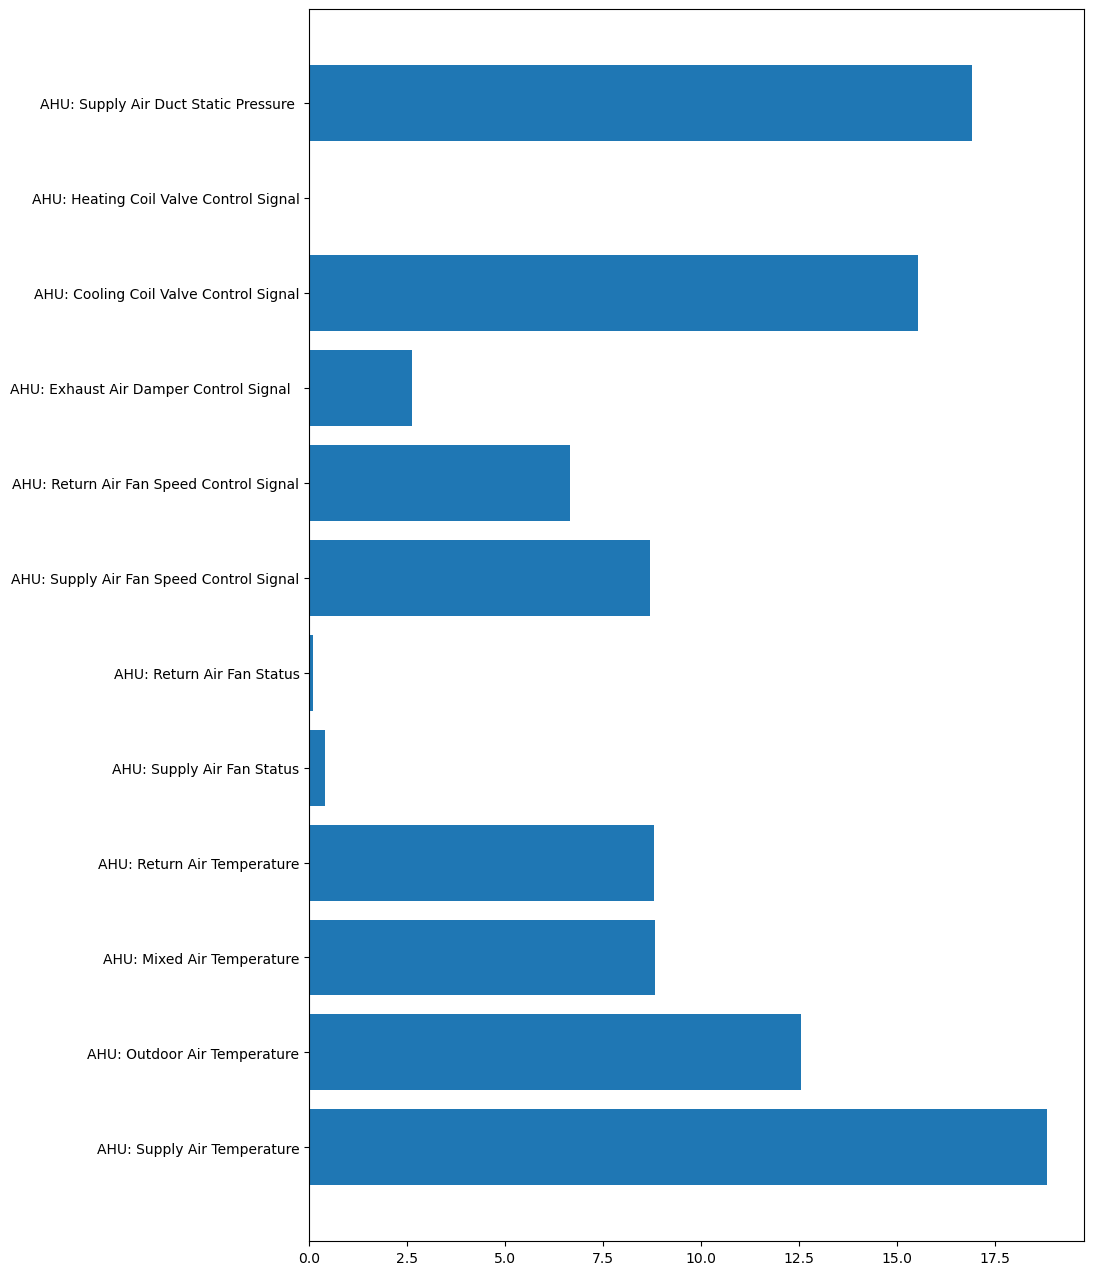

In [114]:
plt.figure(figsize=(10,16))
plt.barh(X_sim.columns, models_heat[4].get_feature_importance())

The weights above appear to align logically with the system's operational dynamics. Notably, differences exist between this model and the model constructed using experimental data. These differences could arise from distinct characteristics of the simulated and experimental datasets, reflecting the variability between these two sources of information.

# Simulation and experimental model comparison

Currently, we possess two categories of models originating from an alternate data source. Despite their distinct origins, these models share a common objective: detecting malfunctioning heating valve leaks within the similar systems. Consequently, it becomes viable to conduct a comparative analysis of these models' performance when applied to different datasets. This assessment will shed light on the models' versatility and adaptability across varied data contexts.

## Model trained on experimnetal data -  predict on an simulated data

In [115]:
Acc_exp_on_sim = pd.DataFrame(index=None, columns=['model','accuracy','precision','recall','f1'])

In [116]:
# Preparing feature data with columns from the experimental data model.
X_exp_on_sim = raw_data_sim[X_exp.columns]

In [117]:
for model in models_exp:
    name = str(model).split('Classifier')[0]
    y_pred = model.predict(X_exp_on_sim)
    acc = accuracy_score(y_heat, y_pred)
    prec = precision_score(y_heat, y_pred)    
    rec = recall_score(y_heat, y_pred)
    f1 = f1_score(y_heat, y_pred)
    
    Acc_exp_on_sim = Acc_exp_on_sim.append(pd.Series({'model':name,
                                'accuracy': acc,
                                'precision': prec,
                                'recall': rec,
                                'f1': f1}),ignore_index=True)

In [118]:
print(Acc_exp_on_sim)

                     model  accuracy  precision    recall        f1
0               KNeighbors  0.758387   0.274437  0.665509  0.388619
1                      MLP  0.393563   0.128661  0.737269  0.219089
2                 AdaBoost  0.555155   0.198219  0.937731  0.327261
3         GradientBoosting  0.558868   0.201020  0.949074  0.331769
4  <catboost.core.CatBoost  0.543536   0.189143  0.899306  0.312550
5                      XGB  0.575668   0.198541  0.881713  0.324101
6                  Bagging  0.561912   0.186182  0.829630  0.304115
7             RandomForest  0.578552   0.202565  0.903241  0.330916
8             DecisionTree  0.561672   0.183200  0.809259  0.298765
9     LogisticRegression()  0.448985   0.140337  0.736574  0.235756


The outcomes reveal a substantial decline in the predictive performance of all models, particularly in terms of precision. Notably, the models predicted a significantly higher number of faults compared to the actual occurrences. This trend is consistent across all models, suggesting that the decrease in performance isn't attributed to particular or poor model training. Rather, it is likely a result of the dissimilar dependencies present in the experimental data when compared to the simulated data.

To varify the consistency of this behavior, it is necessary to investigate whether this pattern persists in reverse scenario. 

## Model trained on simulated data - prediction on an experimental data

In [119]:
Acc_sim_on_exp = pd.DataFrame(index=None, columns=['model','accuracy','precision','recall','f1'])

In [120]:
# Preparing feature data with columns from the experimental data model.
X_sim_on_exp = raw_data_exp[X_sim.columns]

In [121]:
for model in models_heat:
    name = str(model).split('Classifier')[0]
    y_pred = model.predict(X_sim_on_exp)
    acc = accuracy_score(y_exp, y_pred)
    prec = precision_score(y_exp, y_pred)    
    rec = recall_score(y_exp, y_pred)
    f1 = f1_score(y_exp, y_pred)
    
    Acc_sim_on_exp = Acc_sim_on_exp.append(pd.Series({'model':name,
                                'accuracy': acc,
                                'precision': prec,
                                'recall': rec,
                                'f1': f1}),ignore_index=True)

In [122]:
print(Acc_sim_on_exp)

                     model  accuracy  precision    recall        f1
0               KNeighbors  0.849352   0.343645  0.142708  0.201668
1                      MLP  0.865926   0.100000  0.000694  0.001379
2                 AdaBoost  0.866435   0.467532  0.012500  0.024349
3         GradientBoosting  0.867269   0.589041  0.014931  0.029123
4  <catboost.core.CatBoost  0.866806   0.520000  0.013542  0.026396
5                      XGB  0.866713   0.505263  0.016667  0.032269
6                  Bagging  0.862778   0.285714  0.019444  0.036411
7             RandomForest  0.868194   0.971429  0.011806  0.023328
8             DecisionTree  0.842824   0.272325  0.106944  0.153578
9     LogisticRegression()  0.867546   0.952381  0.006944  0.013788


In this instance, the models' performance further deteriorated, reaffirming the previous assumptions that the relationships present in real-world data differ from those within the simulated data. This confirmation underscores the significance of data source variability and its impact on the models' ability to generalize effectively.

# Final conclusions

In summation, the outcomes emphasize the viability of employing machine learning models for fault detection within a system. Nevertheless, the choice of data source significantly influences model performance. When utilizing well-constructed data, the majority of models exhibit outstanding performance even without extensive model tuning or data balancing.

Regrettably, the limitation emerges that simulation data might not be suitable for model training. While generating data through simulation offers cost-effective benefits, the resulting model's efficacy is inherently constrained by the accuracy of the simulation model. This essentially creates a scenario where a model is based on another model, presenting limitations for real-world practicality. The ultimate requirement is to develop a model that closely mirrors reality, maximizing its usefulness in real-world applications.